In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# 1. Load dataset

In [6]:
def load_dataset(
    file_path: str = "/kaggle/input/fpt-dataset/synthetized_dataset.csv"
) -> pd.DataFrame:
    # --- Load dataset ---
    output = pd.read_csv(
        file_path,
        parse_dates = ['date'],
    )
    
    # --- Filter Dataset ---
    output = output[output['date']>='01/01/2020']
    output = output[output['date']<'10/01/2025']

    # --- Change date format ---
    output['date'] = pd.to_datetime(
        output['date'], 
        format='%d/%m/%Y', 
        errors='coerce'
    )

    return output   

In [7]:
dataset = load_dataset()
dataset

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date,cpi_rate,gdp_value,usd_vnd_rate,xau_usd_rate,market_cap,pe_ratio,fpt_net_revenue,fpt_gross_profit,fpt_operating_profit,fpt_net_profit,fpt_stock_price,fpt_stock_volume
3411,2020-01-01,NaN,NaN,23171.0,1517.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3412,2020-01-02,NaN,NaN,23175.5,1531.30,NaN,NaN,NaN,NaN,NaN,NaN,21.39,896720.0
3413,2020-01-03,NaN,NaN,23174.5,1553.45,NaN,NaN,NaN,NaN,NaN,NaN,21.03,2047880.0
3414,2020-01-06,NaN,NaN,23178.0,1582.69,NaN,NaN,NaN,NaN,NaN,NaN,20.81,1091660.0
3415,2020-01-07,NaN,NaN,23179.0,1577.38,NaN,NaN,NaN,NaN,NaN,NaN,21.21,837240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,2025-09-24,NaN,NaN,26432.0,3779.54,NaN,NaN,NaN,NaN,NaN,NaN,99.50,7421100.0
4936,2025-09-25,NaN,NaN,26428.0,3761.66,NaN,NaN,NaN,NaN,NaN,NaN,98.00,8627700.0
4937,2025-09-26,NaN,NaN,26422.5,3783.88,NaN,NaN,NaN,NaN,NaN,NaN,97.50,8080800.0
4938,2025-09-29,NaN,NaN,26433.5,3834.58,NaN,NaN,NaN,NaN,NaN,NaN,95.50,10430900.0


# 2. General Description

In [8]:
def investigate_dataset_description(
    _df: pd.DataFrame = dataset
) -> None:
    df = _df.copy()

    print('======================================================')
    print('KẾT QUẢ ĐIỀU TRA DATASET')
    print('======================================================')
    _columns = list(df.columns)
    print(f'Tổng số cột là: {len(_columns)}')
    print(f'Tổng số mẫu là: {len(df)}')
    print(f'Các cột là    : {_columns}')
    print()
    print(df.info())
    print()
    print(df.describe())

investigate_dataset_description(dataset)

KẾT QUẢ ĐIỀU TRA DATASET
Tổng số cột là: 13
Tổng số mẫu là: 1529
Các cột là    : ['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate', 'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit', 'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price', 'fpt_stock_volume']

<class 'pandas.core.frame.DataFrame'>
Index: 1529 entries, 3411 to 4939
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1529 non-null   datetime64[ns]
 1   cpi_rate              68 non-null     float64       
 2   gdp_value             5 non-null      float64       
 3   usd_vnd_rate          1501 non-null   float64       
 4   xau_usd_rate          1495 non-null   float64       
 5   market_cap            19 non-null     float64       
 6   pe_ratio              19 non-null     float64       
 7   fpt_net_revenue       22 non-null     float64       
 8   fpt_gross_profit

# 3. Phân tích đơn biến

## 3.0. Các hàm dùng lại

In [9]:
def investigate_variable(
    dataset,
    column_name,
    date_name = 'date'
):
    column = dataset[column_name]
    date   = dataset[date_name]

    print(f'\n----- THỐNG KÊ GIÁ TRỊ MISSING {column_name} -----')
    num_of_missing = dataset[column_name].isnull().sum()
    num_of_value   = len(dataset[column_name])

    print(f'Tổng số giá trị khả dụng   : {num_of_value - num_of_missing}')
    print(f'Tổng số giá trị rỗng       : {num_of_missing}')
    print(f'Tỉ lệ giá trị rỗng         : {round(num_of_missing/num_of_value*100, 2)}%')

    # --- Statistics ---
    MEAN = dataset[column_name].mean()
    MIN = dataset[column_name].min()
    Q1 = dataset[column_name].quantile(0.25)
    Q2 = dataset[column_name].quantile(0.5)
    Q3 = dataset[column_name].quantile(0.75)
    MAX = dataset[column_name].max()
    IQR = Q3 - Q1

    print(f'\n----- CHỈ SỐ THỐNG KÊ CHO CỘT {column_name} -----')
    print(f'Giá trị trung bình         : {round(MEAN, 5)}')

    print(f'Giá trị nhỏ nhất           : {round(MIN, 5)}')
    print(f'Q1 (25th percentile)       : {round(Q1, 5)}')
    print(f'Q2 (Trung vị)              : {round(Q2, 5)}')
    print(f'Q3 (75th percentile)       : {round(Q3, 5)}')
    print(f'Giá trị lớn nhất           : {round(MAX, 5)}')
    print(f'IQR                        : {round(IQR, 5)}')

investigate_variable(
    dataset,
    'cpi_rate'
)


----- THỐNG KÊ GIÁ TRỊ MISSING cpi_rate -----
Tổng số giá trị khả dụng   : 68
Tổng số giá trị rỗng       : 1461
Tỉ lệ giá trị rỗng         : 95.55%

----- CHỈ SỐ THỐNG KÊ CHO CỘT cpi_rate -----
Giá trị trung bình         : 0.03051
Giá trị nhỏ nhất           : -0.0097
Q1 (25th percentile)       : 0.0246
Q2 (Trung vị)              : 0.0305
Q3 (75th percentile)       : 0.036
Giá trị lớn nhất           : 0.0643
IQR                        : 0.0114


In [10]:
def decompose_time_series(
    dataset,
    column_name,
    date_name='date',
    period=12,
    model='additive',
    freq='M'
):
    """
    Phân tích cấu trúc chuỗi thời gian phổ quát, hỗ trợ tần suất khác nhau (D, W, M, Q).
    
    Tham số:
    - freq (str): Tần suất chuẩn hóa (ví dụ: 'D', 'W', 'M', 'Q').
    - period (int): Chu kỳ của tính mùa vụ (ví dụ: 7 cho W, 12 cho M, 4 cho Q).
    """
    
    print(f"\n----- BẮT ĐẦU PHÂN TÍCH DECOMPOSITION: {column_name} (Freq: {freq}) -----")
    
    # --- Chuẩn bị dữ liệu ---
    try:
        df_ts = dataset.set_index(date_name).copy()
    except KeyError:
        print(f"LỖI: DataFrame không có cột '{date_name}'. Hãy kiểm tra tên cột ngày tháng.")
        return None

    # --- Trích xuất Series ---
    series = df_ts[column_name]
    
    if series.empty:
        print("LỖI: Series trống.")
        return None
        
    # --- Chuẩn hóa + xử lý missing value
    try:
        series_freq = series.asfreq(freq)
    except Exception as e:
        print(f"LỖI: Không thể chuyển đổi sang tần suất '{freq}'. Lỗi: {e}")
        return None
        
    # --- Nội suy Linear (nếu còn chỗ trống) ---
    series_final = series_freq.interpolate(method='linear').bfill().dropna()

    if len(series_final) < period * 2:
        print(f"LỖI: Chuỗi quá ngắn ({len(series_final)} điểm). Cần ít nhất 2 chu kỳ ({period*2} điểm) cho phân tích.")
        return None
    
    # --- Thực hiện phân rã và trực quan hóa ---
    try:
        decomposition = seasonal_decompose(
            series_final,
            model=model,
            period=period
        )
        
        fig, axes = plt.subplots(
            nrows=4, 
            ncols=1, 
            figsize=(10, 8),  
            sharex=True   
        )
        decomposition.observed.plot(ax=axes[0], title='Observed',grid=True)
        decomposition.trend.plot(ax=axes[1], title='Trend',grid=True)
        decomposition.seasonal.plot(ax=axes[2], title='Seasonal',grid=True)
        decomposition.resid.plot(ax=axes[3], title='Residual',grid=True)
        
        fig.suptitle(f'Decomposition của {column_name} (Model: {model})', y=1.02)
        fig.tight_layout() 
        plt.show()
        
        # --- Trả về kết quả ---
        return decomposition
        
    except ValueError as e:
        print(f"LỖI PHÂN TÍCH: {e}")
        print("Gợi ý: Hãy kiểm tra lại tham số 'period'. Chu kỳ phải lớn hơn 1 và nhỏ hơn số lượng quan sát.")
        return None

In [11]:
def check_stationarity(series, alpha=0.05, title='Chuỗi thời gian'):
    """
    Thực hiện kiểm định Augmented Dickey-Fuller (ADF) và trực quan hóa chuỗi.
    
    Tham số:
    - series (pd.Series): Chuỗi thời gian (cần có DatetimeIndex).
    - alpha (float): Mức ý nghĩa (mặc định 0.05, tương đương 5%).
    - title (str): Tiêu đề cho biểu đồ.
    """
    
    print(f"\n----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: {title} -----")
    
    # --- Thực hiện Kiểm định ADF ---
    # 'ct' nghĩa là bao gồm hằng số (c) và xu hướng (t) trong kiểm định
    result = adfuller(series, autolag='AIC', regression='ct') 
    
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # --- In kết quả ---
    print(f"Chỉ số ADF (ADF Statistic)      : {adf_statistic:.4f}")
    print(f"Giá trị p (P-value)             : {p_value:.6f}")
    print(f"Ngưỡng ý nghĩa (Critical Value) :")
    for key, value in critical_values.items():
        print(f"  {key}: {value:.4f}")
    
    # --- Kết luận ---
    is_stationary = p_value < alpha
    print("-" * 50)
    if is_stationary:
        print(f"KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < {alpha}). Bác bỏ H0.")
    else:
        print(f"KẾT LUẬN: Chuỗi KHÔNG CÓ TÍNH DỪNG (P-value >= {alpha}). Chấp nhận H0.")
    print("-" * 50)

    # --- Trực quan hóa --- 
    plt.figure(figsize=(10, 4))
    plt.plot(series, label='Dữ liệu Gốc', color='blue')
    plt.title(f'{title} (Stationary: {is_stationary})')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị')
    plt.grid(True)
    plt.legend()
    plt.show()

    return is_stationary, p_value

In [39]:
def log_differencing(
    series: pd.Series,
    periods: int = 1
) -> pd.Series:
    """
    Tính toán sai phân logarit (Log Differencing), hay lợi nhuận logarit.

    Công thức: Delta_ln(Y_t) = ln(Y_t) - ln(Y_{t-k})

    Args:
        series (pd.Series): Chuỗi dữ liệu chuỗi thời gian đầu vào (ví dụ: tỷ giá, giá vàng).
        periods (int): Khoảng thời gian để lấy sai phân (mặc định là 1).

    Returns:
        pd.Series: Chuỗi dữ liệu đã lấy sai phân log.
    """
    log_series = np.log(series)
    diff_log_series = log_series.diff(periods=periods)
    diff_log_series.name = f"log_return_{series.name}"
    
    return diff_log_series

## 3.1. Biến `cpi_rate`

> Chỉ số CPI (Consumer Price Index) là một chỉ báo kinh tế đo lường sự thay đổi giá trung bình của một "giỏ" các hàng hóa và dịch vụ thiết yếu mà người dân thường dùng (như thực phẩm, y tế, giáo dục, nhà ở) theo thời gian, phản ánh chính xác mức độ lạm phát hay giảm phát của nền kinh tế.


----- THỐNG KÊ GIÁ TRỊ MISSING cpi_rate -----
Tổng số giá trị khả dụng   : 68
Tổng số giá trị rỗng       : 1461
Tỉ lệ giá trị rỗng         : 95.55%

----- CHỈ SỐ THỐNG KÊ CHO CỘT cpi_rate -----
Giá trị trung bình         : 0.03051
Giá trị nhỏ nhất           : -0.0097
Q1 (25th percentile)       : 0.0246
Q2 (Trung vị)              : 0.0305
Q3 (75th percentile)       : 0.036
Giá trị lớn nhất           : 0.0643
IQR                        : 0.0114


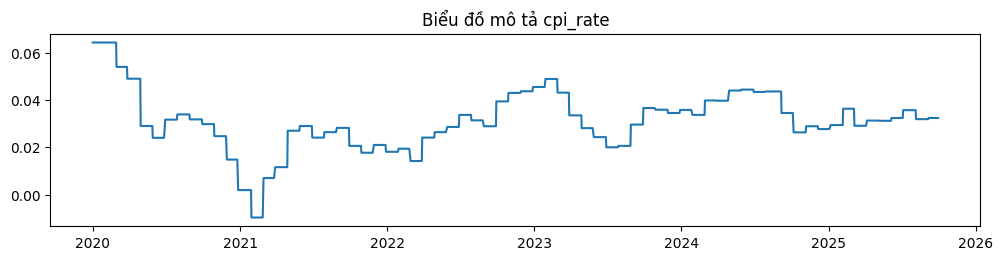


----- BẮT ĐẦU PHÂN TÍCH DECOMPOSITION: cpi_rate (Freq: M) -----


/tmp/ipykernel_48/2710428928.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series_freq = series.asfreq(freq)


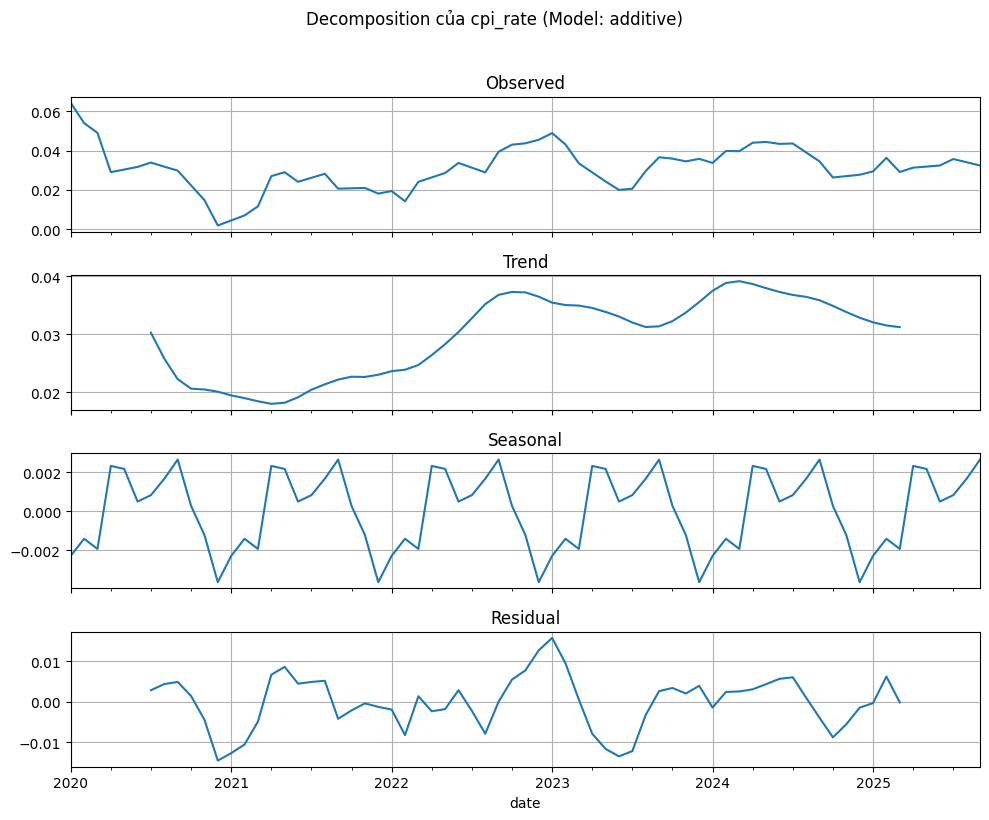


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Phần dư (Residuals) -----
Chỉ số ADF (ADF Statistic)      : -4.0369
Giá trị p (P-value)             : 0.007788
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1755
  5%: -3.5130
  10%: -3.1867
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


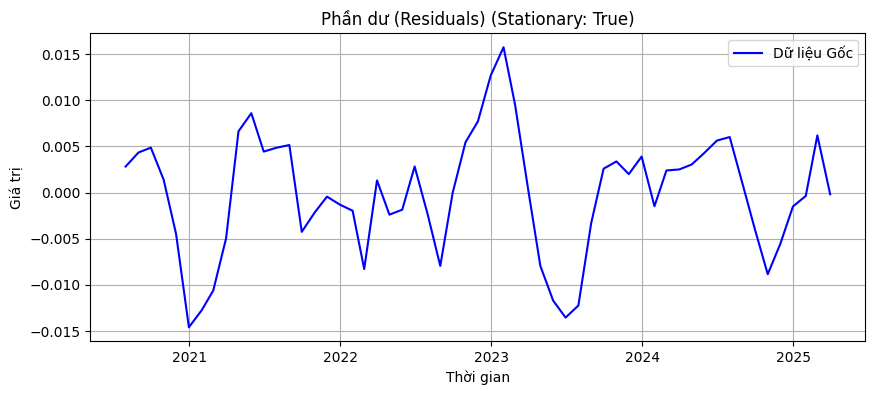


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: CPI Đã Khử Mùa vụ (Trend + Residuals) -----
Chỉ số ADF (ADF Statistic)      : -4.0716
Giá trị p (P-value)             : 0.006938
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1406
  5%: -3.4968
  10%: -3.1774
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


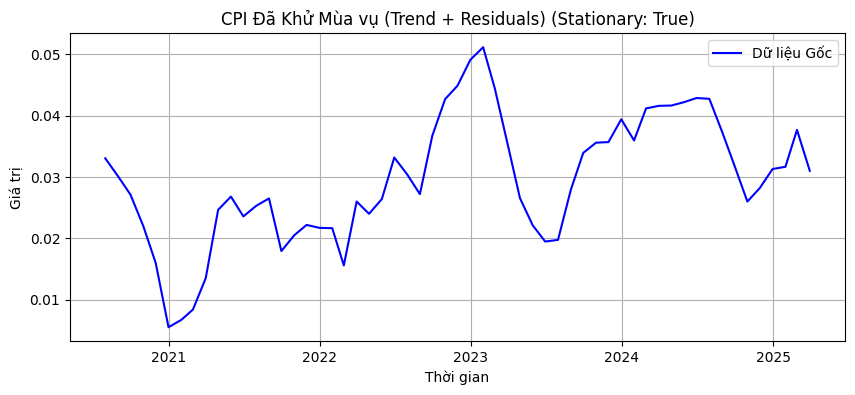

TIẾN HÀNH SAI PHÂN


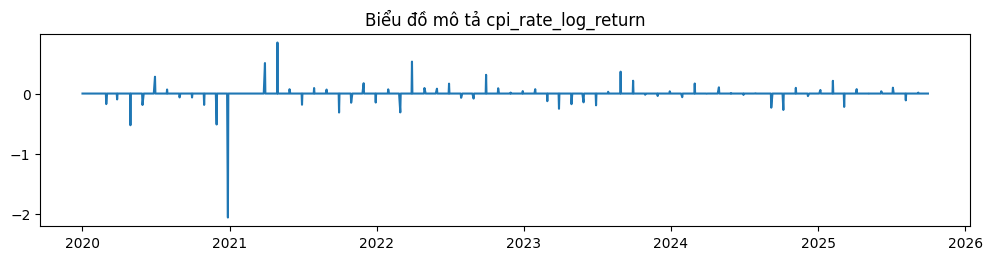


----- BẮT ĐẦU PHÂN TÍCH DECOMPOSITION: cpi_rate_log_return (Freq: M) -----


/tmp/ipykernel_48/2710428928.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series_freq = series.asfreq(freq)


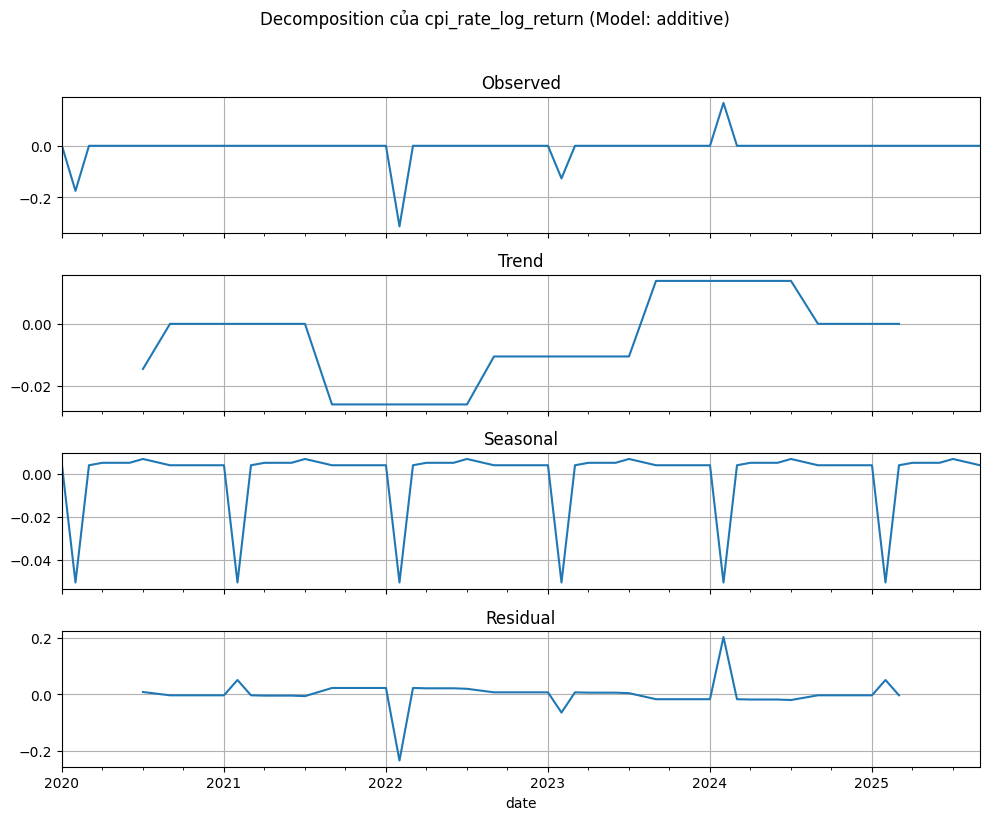


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Phần dư (Residuals) -----
Chỉ số ADF (ADF Statistic)      : -8.0508
Giá trị p (P-value)             : 0.000000
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1303
  5%: -3.4920
  10%: -3.1746
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


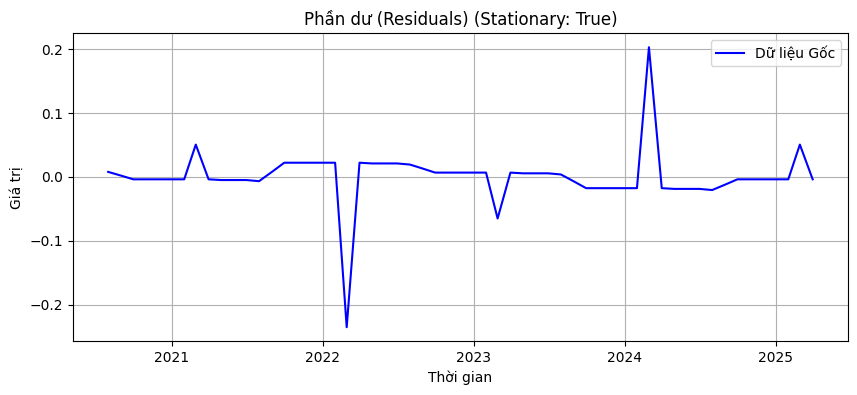


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: CPI Đã Khử Mùa vụ (Trend + Residuals) -----
Chỉ số ADF (ADF Statistic)      : -7.4131
Giá trị p (P-value)             : 0.000000
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1303
  5%: -3.4920
  10%: -3.1746
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


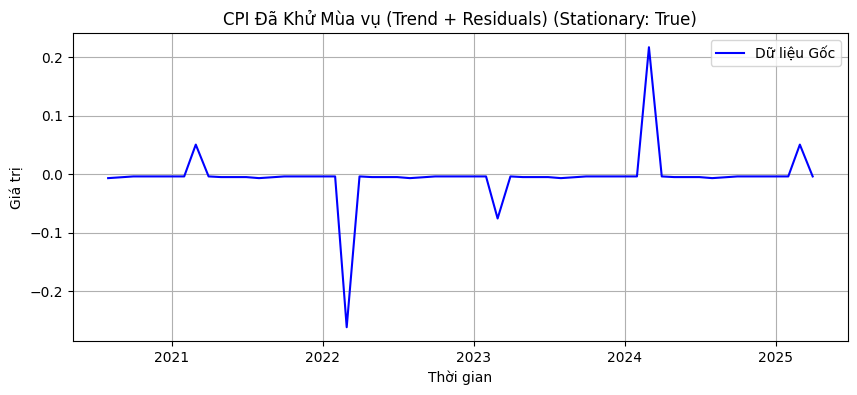

In [52]:
def EDA_cpi(
   _df = dataset
) -> None:
    df = _df.copy()
    column_name = 'cpi_rate'
    
    investigate_variable(df, column_name)
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()
    
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name}")
    plt.show()

    # --- Phân rã ---
    decomposed = decompose_time_series(
        df,
        column_name,
        date_name='date',
        period=12,
        model='additive',
        freq='M'
    )
    if decomposed is None:
        print("PHÂN TÍCH DECOMPOSITION THẤT BẠI. KHÔNG THỂ TIẾP TỤC KIỂM ĐỊNH TÍNH DỪNG.")
        return

    # --- Kiểm định tính dừng ---
    is_resid_stationary, p_resid = check_stationarity(
        decomposed.resid.dropna(), 
        title='Phần dư (Residuals)'
    )
    cpi_sa = decomposed.trend.dropna() + decomposed.resid.dropna()
    result_sa = check_stationarity(
        cpi_sa, 
        title='CPI Đã Khử Mùa vụ (Trend + Residuals)'
    )

    
    # --- Sai phân ---
    print('================================================')
    print('TIẾN HÀNH SAI PHÂN')
    print('================================================')
    new_column_name = 'cpi_rate_log_return'
    df[new_column_name] = log_differencing(df[column_name], periods=1)
    column_name = new_column_name
    df[column_name] = df[column_name].bfill()
    df[column_name] = df[column_name].ffill()

    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name}")
    plt.show()

    # --- Phân rã ---
    decomposed = decompose_time_series(
        df,
        column_name,
        date_name='date',
        period=12,
        model='additive',
        freq='M'
    )
    if decomposed is None:
        print("PHÂN TÍCH DECOMPOSITION THẤT BẠI. KHÔNG THỂ TIẾP TỤC KIỂM ĐỊNH TÍNH DỪNG.")
        return

    # --- Kiểm định tính dừng ---
    is_resid_stationary, p_resid = check_stationarity(
        decomposed.resid.dropna(), 
        title='Phần dư (Residuals)'
    )
    cpi_sa = decomposed.trend.dropna() + decomposed.resid.dropna()
    result_sa = check_stationarity(
        cpi_sa, 
        title='CPI Đã Khử Mùa vụ (Trend + Residuals)'
    )

    scaler = StandardScaler()
    gdp_scaled = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    df[column_name] = pd.Series(gdp_scaled.flatten(), index=df.index)
    
EDA_cpi(
    dataset
)
    

## 3.2. Giá trị GDP

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [14]:
dataset.columns

Index(['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate',
       'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit',
       'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price',
       'fpt_stock_volume'],
      dtype='object')


----- THỐNG KÊ GIÁ TRỊ MISSING gdp_value -----
Tổng số giá trị khả dụng   : 5
Tổng số giá trị rỗng       : 1524
Tỉ lệ giá trị rỗng         : 99.67%

----- CHỈ SỐ THỐNG KÊ CHO CỘT gdp_value -----
Giá trị trung bình         : 407356326732.572
Giá trị nhỏ nhất           : 346615738537.8
Q1 (25th percentile)       : 366474752771.01
Q2 (Trung vị)              : 413445230668.58
Q3 (75th percentile)       : 433857681378.29
Giá trị lớn nhất           : 476388230307.18
IQR                        : 67382928607.27997


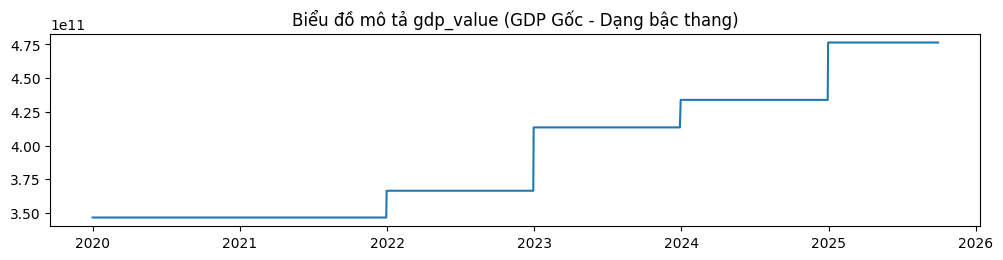

TIẾN HÀNH CHUẨN HÓA (StandardScaler)
✅ Đã hoàn tất xử lý cho gdp_value. Dữ liệu đã được Scale và sẵn sàng cho XGBoost.


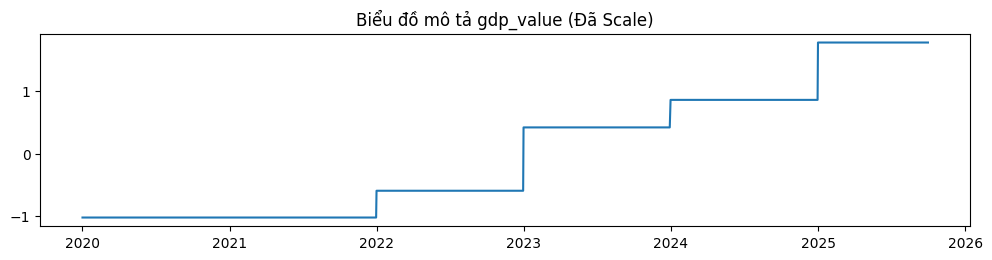

In [80]:
def EDA_gdp(
   _df = dataset
)-> None:
    df = _df.copy()
    column_name = 'gdp_value'
    
    investigate_variable(df, column_name)
    
    # --- Điền missing value ---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()
    
    # --- Visualize ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (GDP Gốc - Dạng bậc thang)")
    plt.show() 

    # --- Chuẩn hóa ---
    print('================================================')
    print('TIẾN HÀNH CHUẨN HÓA (StandardScaler)')
    print('================================================')
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    df[column_name] = pd.Series(scaled_data.flatten(), index=df.index)
    
    # --- Trực quan hóa (sau scale) ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Đã Scale)")
    plt.show()
    
EDA_gdp(dataset)
    

## 3.3. Tỉ giá `usd_vnd_rate`

In [28]:
dataset.columns

Index(['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate',
       'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit',
       'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price',
       'fpt_stock_volume'],
      dtype='object')


----- THỐNG KÊ GIÁ TRỊ MISSING usd_vnd_rate -----
Tổng số giá trị khả dụng   : 1501
Tổng số giá trị rỗng       : 28
Tỉ lệ giá trị rỗng         : 1.83%

----- CHỈ SỐ THỐNG KÊ CHO CỘT usd_vnd_rate -----
Giá trị trung bình         : 24003.6992
Giá trị nhỏ nhất           : 22645.0
Q1 (25th percentile)       : 23142.5
Q2 (Trung vị)              : 23510.0
Q3 (75th percentile)       : 24860.0
Giá trị lớn nhất           : 26457.0
IQR                        : 1717.5


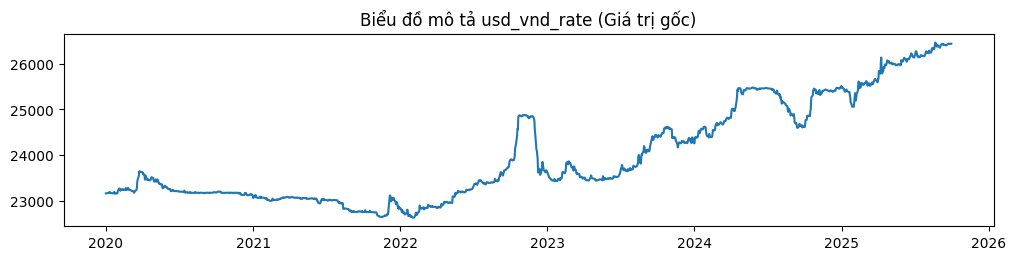

TIẾN HÀNH SAI PHÂN LOG (Tạo Log Returns)


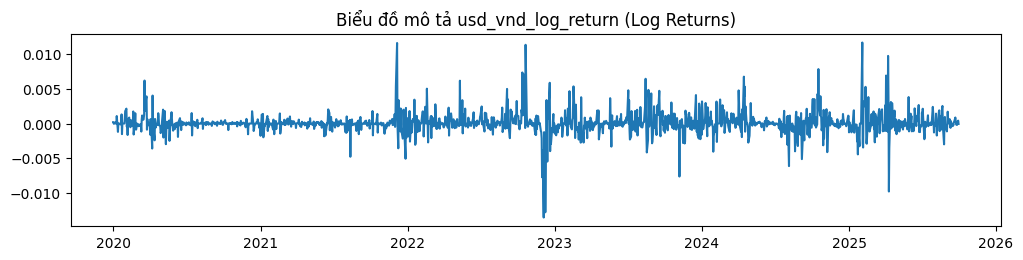


----- BẮT ĐẦU PHÂN TÍCH DECOMPOSITION: usd_vnd_log_return (Freq: M) -----


/tmp/ipykernel_48/2710428928.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series_freq = series.asfreq(freq)


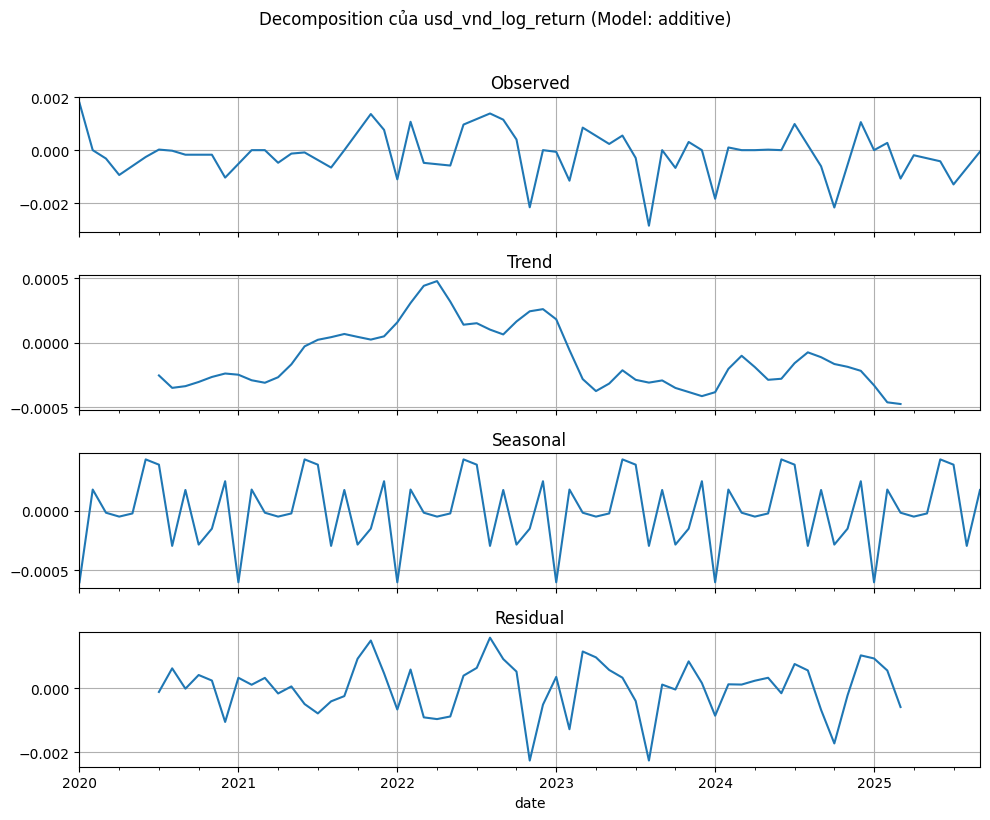


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Phần dư (Residuals) của Log Returns -----
Chỉ số ADF (ADF Statistic)      : -4.2625
Giá trị p (P-value)             : 0.003595
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1755
  5%: -3.5130
  10%: -3.1867
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


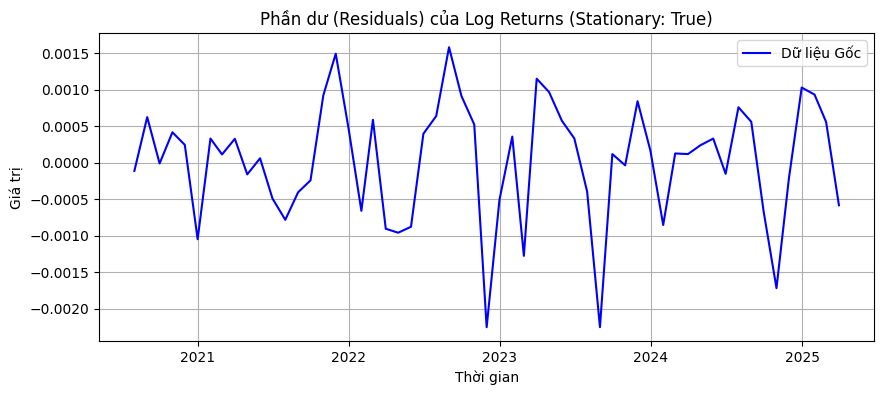


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: USD/VND Log Return Đã Khử Mùa vụ -----
Chỉ số ADF (ADF Statistic)      : -4.7597
Giá trị p (P-value)             : 0.000551
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1406
  5%: -3.4968
  10%: -3.1774
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


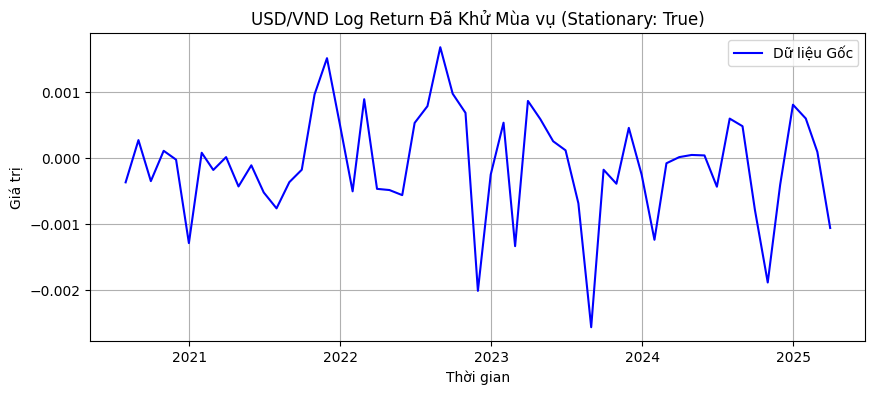

In [54]:
def EDA_usd_vnd(_df = dataset) -> None:
    df = _df.copy()
    column_name = 'usd_vnd_rate'
    new_column_name = 'usd_vnd_log_return'
    
    investigate_variable(df, column_name)
    
    # --- Điền missing value ---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()
    
    # --- Visualize ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Giá trị gốc)")
    plt.show()
    
    # --- Sai phân tạo log returns ---
    print('================================================')
    print('TIẾN HÀNH SAI PHÂN LOG (Tạo Log Returns)')
    print('================================================')
    df[new_column_name] = log_differencing(df[column_name], periods=1)
    column_name = new_column_name
    df[column_name] = df[column_name].bfill()
    df[column_name] = df[column_name].ffill()
    
    # --- Trực quan hóa ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Log Returns)")
    plt.show()

    # --- Phân rã trên log returns ---
    decomposed = decompose_time_series(
        df,
        column_name,
        date_name='date',
        period=12,
        model='additive',
        freq='M' 
    )
    if decomposed is None:
        print("PHÂN TÍCH DECOMPOSITION THẤT BẠI. KHÔNG THỂ TIẾP TỤC KIỂM ĐỊNH TÍNH DỪNG.")
        return

    # --- Kiểm định tính dừng ---
    is_resid_stationary, p_resid = check_stationarity(
        decomposed.resid.dropna(), 
        title='Phần dư (Residuals) của Log Returns'
    )
    
    cpi_sa = decomposed.trend.dropna() + decomposed.resid.dropna()
    result_sa = check_stationarity(
        cpi_sa, 
        title='USD/VND Log Return Đã Khử Mùa vụ' 
    )
    
    # --- Chuẩn hóa ---
    scaler = StandardScaler()
    gdp_scaled = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    df[column_name] = pd.Series(gdp_scaled.flatten(), index=df.index)
    
EDA_usd_vnd(dataset)
    

## 3.4. Biến `XAU_USD_RATE`

In [37]:
dataset.columns

Index(['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate',
       'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit',
       'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price',
       'fpt_stock_volume'],
      dtype='object')


----- THỐNG KÊ GIÁ TRỊ MISSING xau_usd_rate -----
Tổng số giá trị khả dụng   : 1495
Tổng số giá trị rỗng       : 34
Tỉ lệ giá trị rỗng         : 2.22%

----- CHỈ SỐ THỐNG KÊ CHO CỘT xau_usd_rate -----
Giá trị trung bình         : 2118.44554
Giá trị nhỏ nhất           : 1501.61
Q1 (25th percentile)       : 1802.01
Q2 (Trung vị)              : 1919.99
Q3 (75th percentile)       : 2331.495
Giá trị lớn nhất           : 3871.87
IQR                        : 529.485


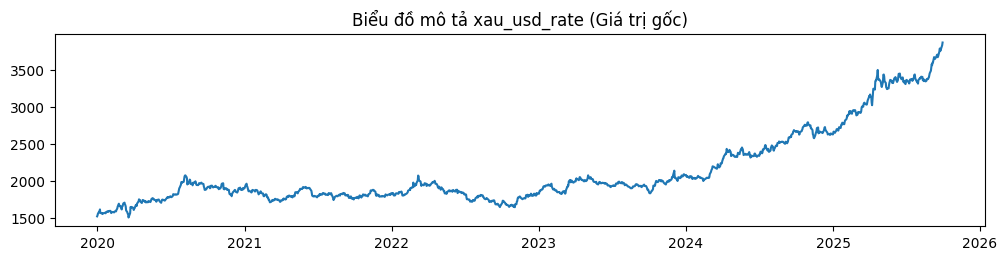

TIẾN HÀNH SAI PHÂN LOG (Tạo Log Returns)


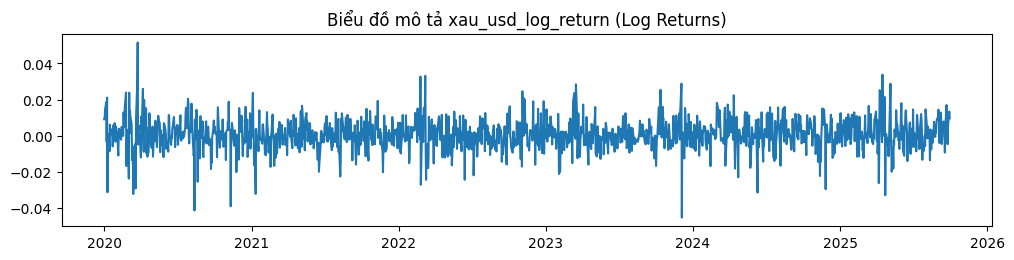


----- BẮT ĐẦU PHÂN TÍCH DECOMPOSITION: xau_usd_log_return (Freq: M) -----


/tmp/ipykernel_48/2710428928.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series_freq = series.asfreq(freq)


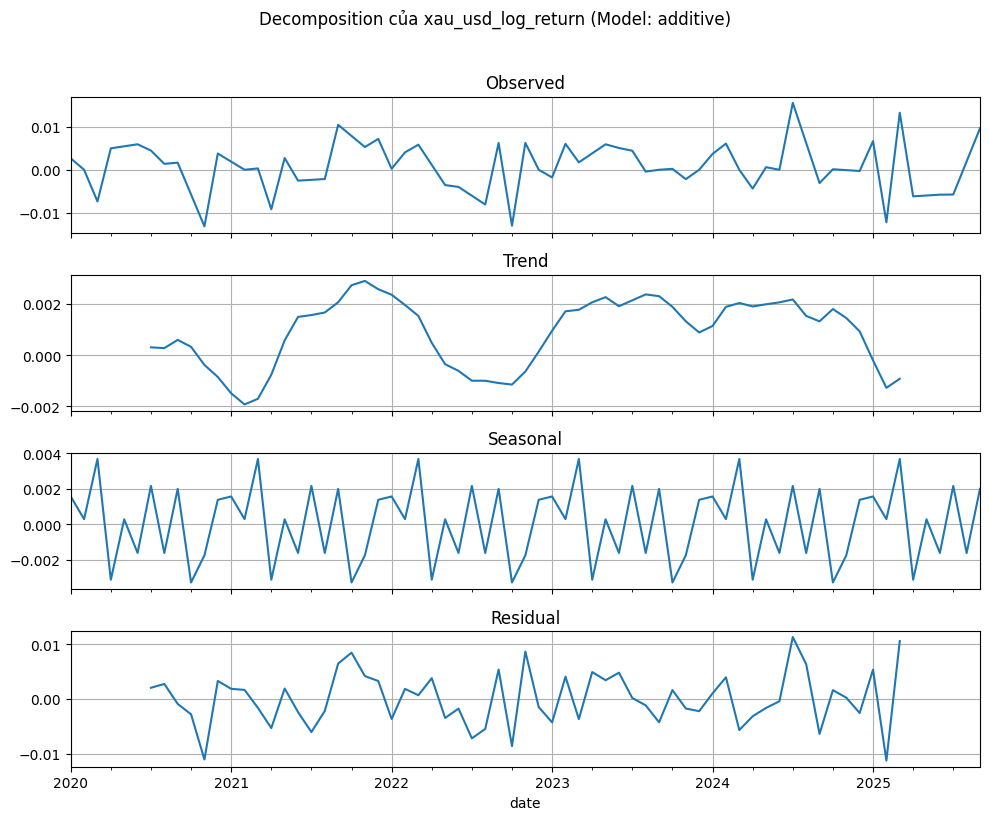


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Phần dư (Residuals) của Log Returns -----
Chỉ số ADF (ADF Statistic)      : -4.2080
Giá trị p (P-value)             : 0.004354
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1755
  5%: -3.5130
  10%: -3.1867
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


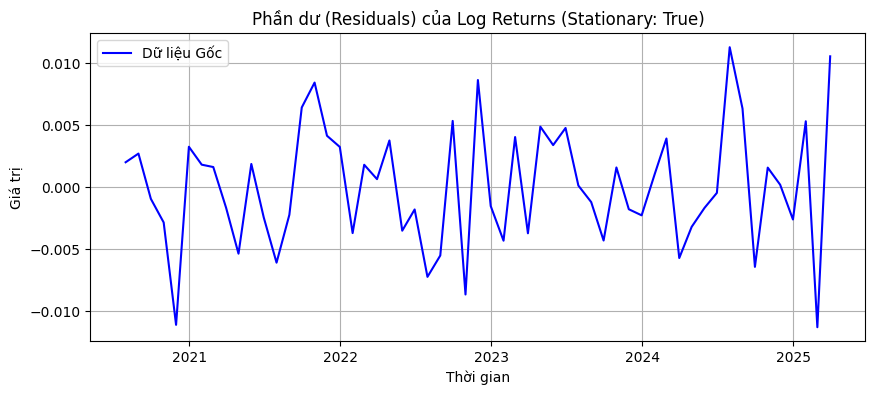


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: XAU/USD Log Return Đã Khử Mùa vụ -----
Chỉ số ADF (ADF Statistic)      : -4.3881
Giá trị p (P-value)             : 0.002288
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1704
  5%: -3.5107
  10%: -3.1853
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


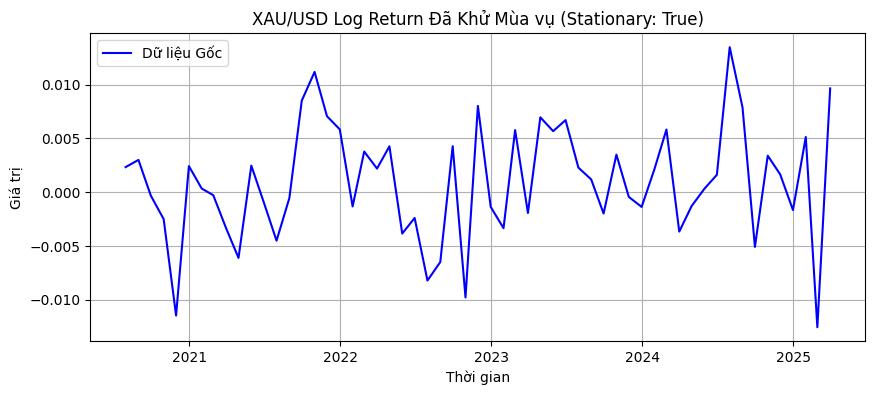

In [60]:
def EDA_usd_vnd(_df = dataset) -> None:
    df = _df.copy()
    column_name = 'xau_usd_rate'
    new_column_name = 'xau_usd_log_return'
    
    investigate_variable(df, column_name)
    
    # --- Điền missing value ---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()
    
    # --- Trực quan hóa ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Giá trị gốc)")
    plt.show()

    
    # --- Lấy sai phân tạo log returns ---
    print('================================================')
    print('TIẾN HÀNH SAI PHÂN LOG (Tạo Log Returns)')
    print('================================================')
    df[new_column_name] = log_differencing(df[column_name], periods=1)
    column_name = new_column_name
    df[column_name] = df[column_name].bfill()
    df[column_name] = df[column_name].ffill()
    
    # --- Visualize ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Log Returns)")
    plt.show()

    # --- Phân rã ---
    decomposed = decompose_time_series(
        df,
        column_name,
        date_name='date',
        period=12,
        model='additive',
        freq='M' 
    )
    if decomposed is None:
        print("PHÂN TÍCH DECOMPOSITION THẤT BẠI. KHÔNG THỂ TIẾP TỤC KIỂM ĐỊNH TÍNH DỪNG.")
        return

    # --- Kiểm định ---
    is_resid_stationary, p_resid = check_stationarity(
        decomposed.resid.dropna(), 
        title='Phần dư (Residuals) của Log Returns'
    )
    
    cpi_sa = decomposed.trend.dropna() + decomposed.resid.dropna()
    result_sa = check_stationarity(
        cpi_sa, 
        title='XAU/USD Log Return Đã Khử Mùa vụ'
    )
    
    # --- Chuẩn hóa ---
    scaler = StandardScaler()
    gdp_scaled = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    df[column_name] = pd.Series(gdp_scaled.flatten(), index=df.index)
    
EDA_usd_vnd(dataset)
    

In [61]:
dataset.columns

Index(['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate',
       'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit',
       'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price',
       'fpt_stock_volume'],
      dtype='object')

## 3.5. Chỉ số `market_cap`


----- THỐNG KÊ GIÁ TRỊ MISSING market_cap -----
Tổng số giá trị khả dụng   : 19
Tổng số giá trị rỗng       : 1510
Tỉ lệ giá trị rỗng         : 98.76%

----- CHỈ SỐ THỐNG KÊ CHO CỘT market_cap -----
Giá trị trung bình         : 126036842105263.17
Giá trị nhỏ nhất           : 42100000000000.0
Q1 (25th percentile)       : 90450000000000.0
Q2 (Trung vị)              : 113800000000000.0
Q3 (75th percentile)       : 168500000000000.0
Giá trị lớn nhất           : 241800000000000.0
IQR                        : 78050000000000.0


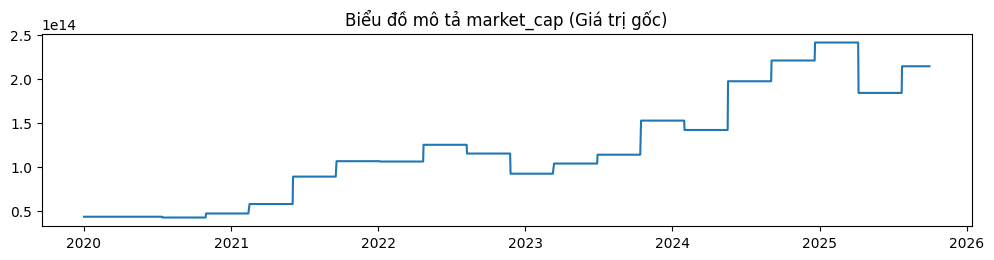

TIẾN HÀNH SAI PHÂN LOG (Tạo Log Returns)


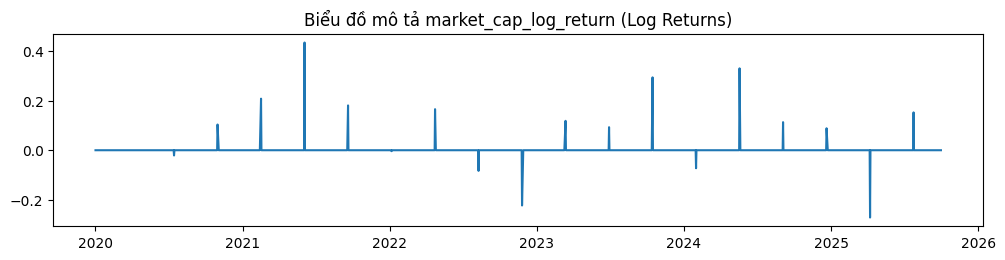


----- BẮT ĐẦU PHÂN TÍCH DECOMPOSITION: market_cap_log_return (Freq: ME) -----


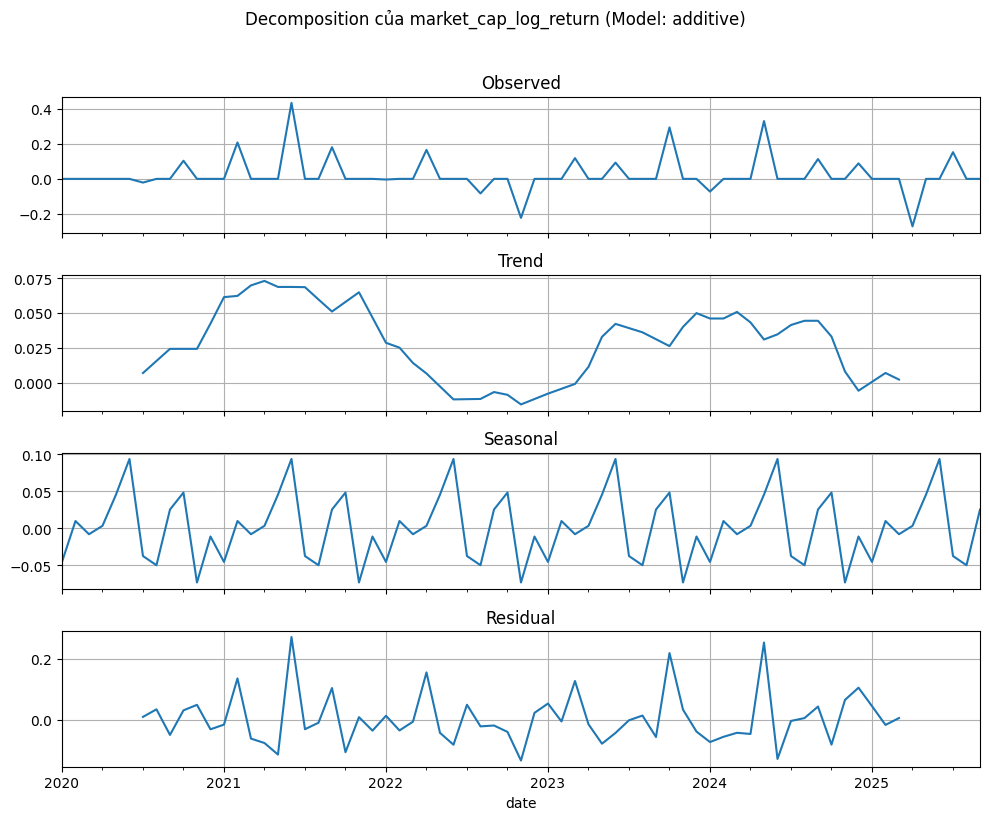


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Phần dư (Residuals) của Log Returns -----
Chỉ số ADF (ADF Statistic)      : -5.8933
Giá trị p (P-value)             : 0.000004
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1482
  5%: -3.5004
  10%: -3.1794
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


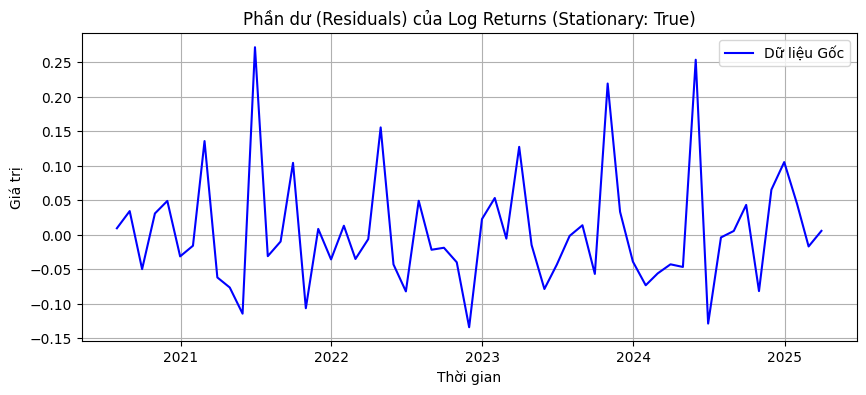


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Market Cap Log Return Đã Khử Mùa vụ -----
Chỉ số ADF (ADF Statistic)      : -8.3979
Giá trị p (P-value)             : 0.000000
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1303
  5%: -3.4920
  10%: -3.1746
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


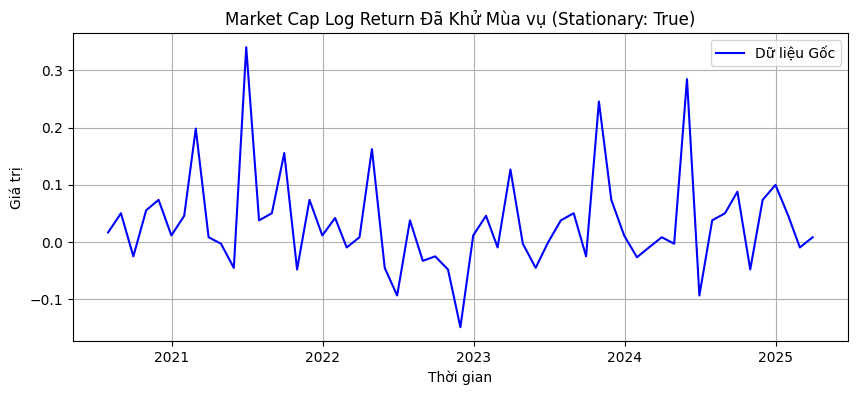

In [63]:
def EDA_market_cap(_df = dataset) -> None:
    df = _df.copy()
    column_name = 'market_cap'
    new_column_name = 'market_cap_log_return'
    investigate_variable(df, column_name)
    
    # --- Điền mising value---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()
    
    # --- trực quan hóa ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Giá trị gốc)")
    plt.show() 

    # --- Lấy sai phân cho log returns ---
    print('================================================')
    print('TIẾN HÀNH SAI PHÂN LOG (Tạo Log Returns)')
    print('================================================')
    df[new_column_name] = log_differencing(df[column_name], periods=1)
    column_name = new_column_name
    df[column_name] = df[column_name].bfill()
    df[column_name] = df[column_name].ffill()
    
    # --- Trực quan hóa
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Log Returns)")
    plt.show()

    # --- Phân rã ---
    df_monthly_analysis = df.set_index('date')[column_name].resample('ME').sum().to_frame() 
    decomposed = decompose_time_series(
        df_monthly_analysis.reset_index(),
        column_name,
        date_name='date',
        period=12,
        model='additive',
        freq='ME' 
    )
    if decomposed is None:
        print("PHÂN TÍCH DECOMPOSITION THẤT BẠI. KHÔNG THỂ TIẾP TỤC KIỂM ĐỊNH TÍNH DỪNG.")
        return

    # --- Kiểm định tính dừng ---
    is_resid_stationary, p_resid = check_stationarity(
        decomposed.resid.dropna(), 
        title='Phần dư (Residuals) của Log Returns'
    )
    
    cpi_sa = decomposed.trend.dropna() + decomposed.resid.dropna()
    result_sa = check_stationarity(
        cpi_sa, 
        title='Market Cap Log Return Đã Khử Mùa vụ'
    )
    
    # --- Chuẩn hóa ---
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[column_name].values.reshape(-1, 1)) 
    df[column_name] = pd.Series(scaled_data.flatten(), index=df.index)

EDA_market_cap(dataset)

In [64]:
dataset.columns

Index(['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate',
       'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit',
       'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price',
       'fpt_stock_volume'],
      dtype='object')

## 3.6. `pe_ratio`


----- THỐNG KÊ GIÁ TRỊ MISSING pe_ratio -----
Tổng số giá trị khả dụng   : 19
Tổng số giá trị rỗng       : 1510
Tỉ lệ giá trị rỗng         : 98.76%

----- CHỈ SỐ THỐNG KÊ CHO CỘT pe_ratio -----
Giá trị trung bình         : 21.19474
Giá trị nhỏ nhất           : 11.9
Q1 (25th percentile)       : 16.2
Q2 (Trung vị)              : 22.0
Q3 (75th percentile)       : 25.05
Giá trị lớn nhất           : 31.1
IQR                        : 8.85


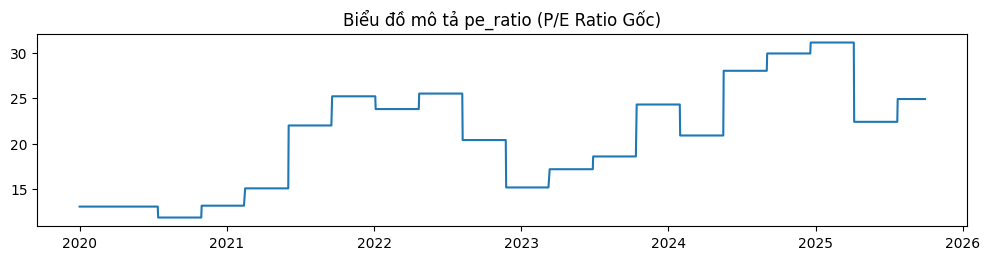

TIẾN HÀNH SAI PHÂN LOG (Tạo Valuation Returns)


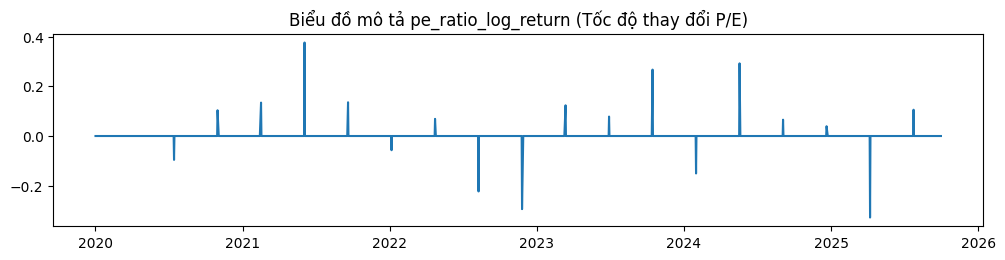


----- BẮT ĐẦU PHÂN TÍCH DECOMPOSITION: pe_ratio_log_return (Freq: M) -----


/tmp/ipykernel_48/2710428928.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series_freq = series.asfreq(freq)


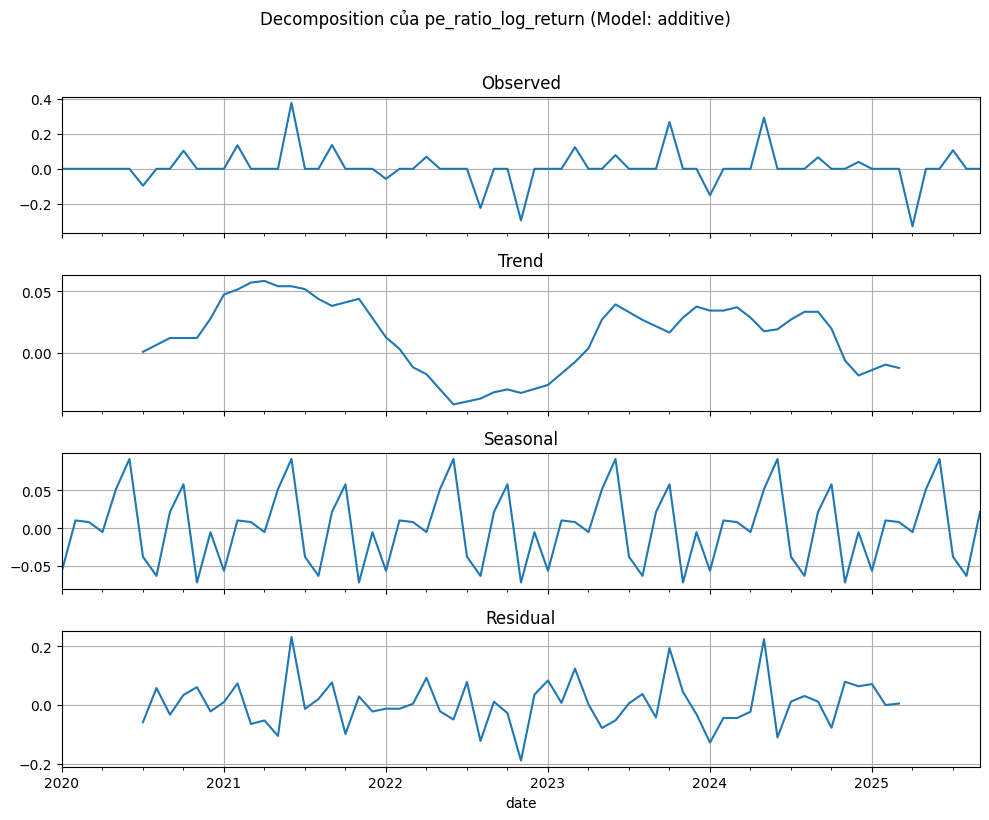


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Phần dư (Residuals) của P/E Returns -----
Chỉ số ADF (ADF Statistic)      : -5.6169
Giá trị p (P-value)             : 0.000013
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1443
  5%: -3.4986
  10%: -3.1784
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


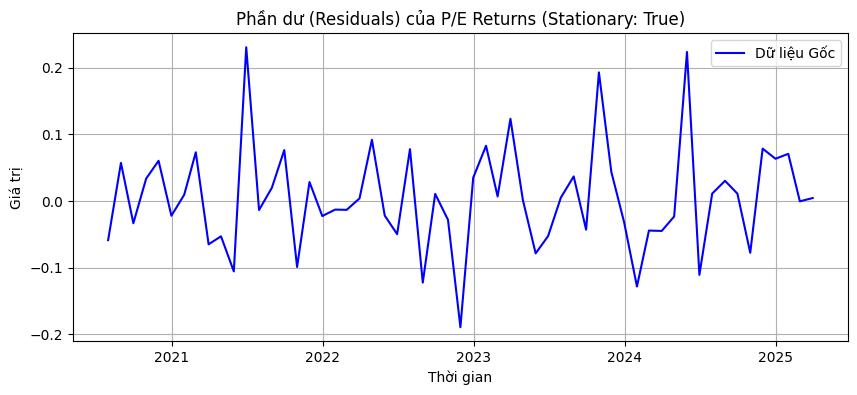


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: P/E Log Return Đã Khử Mùa vụ -----
Chỉ số ADF (ADF Statistic)      : -3.2661
Giá trị p (P-value)             : 0.072024
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1755
  5%: -3.5130
  10%: -3.1867
--------------------------------------------------
KẾT LUẬN: Chuỗi KHÔNG CÓ TÍNH DỪNG (P-value >= 0.05). Chấp nhận H0.
--------------------------------------------------


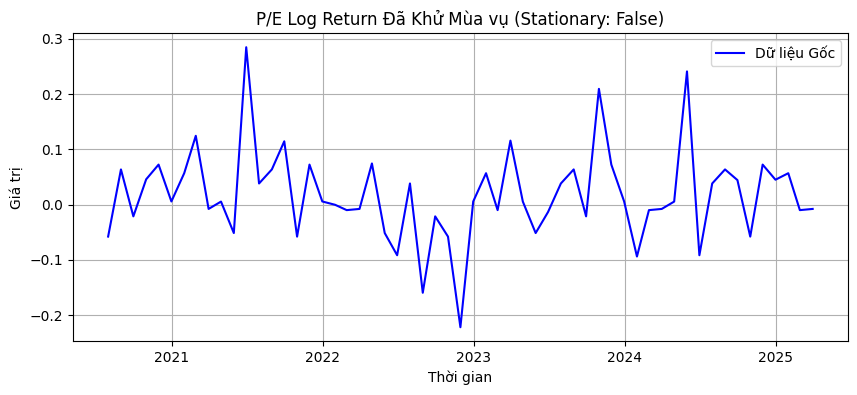

✅ Đã hoàn tất xử lý cho pe_ratio_log_return. Dữ liệu đã được Scale và sẵn sàng cho XGBoost.


In [65]:
def EDA_pe_ratio(_df = dataset) -> None:
    df = _df.copy()
    column_name = 'pe_ratio'
    new_column_name = 'pe_ratio_log_return'
    
    investigate_variable(df, column_name)
    
    # --- missing value ---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()
    
    # --- visualize ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (P/E Ratio Gốc)")
    plt.show() 

    # --- lấy sai phân log ---
    print('================================================')
    print('TIẾN HÀNH SAI PHÂN LOG (Tạo Valuation Returns)')
    print('================================================')
    df[new_column_name] = log_differencing(df[column_name], periods=1)
    column_name = new_column_name
    df[column_name] = df[column_name].bfill()
    df[column_name] = df[column_name].ffill()
    
    # --- Trực quan hóa ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Tốc độ thay đổi P/E)")
    plt.show() 

    # --- Phân rã
    df_monthly_analysis = df.set_index('date')[column_name].resample('ME').sum().to_frame()

    decomposed = decompose_time_series(
        df_monthly_analysis.reset_index(),
        column_name,
        date_name='date',
        period=12,      
        model='additive',
        freq='M' 
    )
    
    if decomposed is None:
        print("PHÂN TÍCH DECOMPOSITION THẤT BẠI.")
        return

    # --- kiểm định tính dừng ---
    is_resid_stationary, p_resid = check_stationarity(
        decomposed.resid.dropna(), 
        title='Phần dư (Residuals) của P/E Returns'
    )
    pe_sa = decomposed.trend.dropna() + decomposed.resid.dropna()
    result_sa = check_stationarity(
        pe_sa, 
        title='P/E Log Return Đã Khử Mùa vụ'
    )
    
    # --- chuẩn hóa ---
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    df[column_name] = pd.Series(scaled_data.flatten(), index=df.index)

EDA_pe_ratio(dataset)

In [66]:
dataset.columns

Index(['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate',
       'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit',
       'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price',
       'fpt_stock_volume'],
      dtype='object')

## 3.7. `fpt_net_revenue`


----- THỐNG KÊ GIÁ TRỊ MISSING fpt_net_revenue -----
Tổng số giá trị khả dụng   : 22
Tổng số giá trị rỗng       : 1507
Tỉ lệ giá trị rỗng         : 98.56%

----- CHỈ SỐ THỐNG KÊ CHO CỘT fpt_net_revenue -----
Giá trị trung bình         : 11711568702724.637
Giá trị nhỏ nhất           : 6630564911438.0
Q1 (25th percentile)       : 8681321448975.75
Q2 (Trung vị)              : 11414968951828.0
Q3 (75th percentile)       : 14541041630917.0
Giá trị lớn nhất           : 17607817805891.0
IQR                        : 5859720181941.251


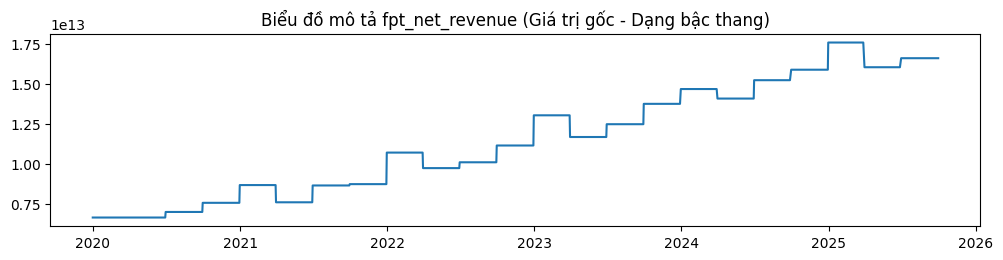

TIẾN HÀNH CHUẨN HÓA (StandardScaler)
✅ Đã xử lý fpt_net_revenue: Giữ nguyên xu hướng bậc thang và Scale.


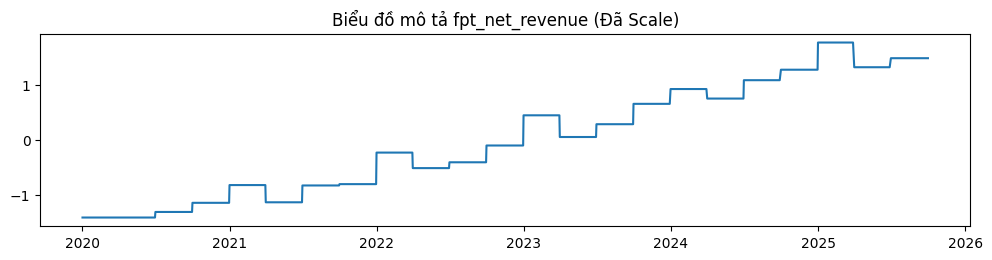

In [72]:
def EDA_fpt_net_revenue(_df = dataset) -> None:
    df = _df.copy()
    column_name = 'fpt_net_revenue'
    
    investigate_variable(df, column_name)
    
    # --- Điền missing value ---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()

    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Giá trị gốc - Dạng bậc thang)")
    plt.show() 

    # --- chuẩn hóa ---
    print('================================================')
    print('TIẾN HÀNH CHUẨN HÓA (StandardScaler)')
    print('================================================')

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    df[column_name] = pd.Series(scaled_data.flatten(), index=df.index)

    # --- Trực quan hóa (sau scale) ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Đã Scale)")
    plt.show()

EDA_fpt_net_revenue(dataset)

In [68]:
dataset.columns

Index(['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate',
       'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit',
       'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price',
       'fpt_stock_volume'],
      dtype='object')

## 3.8. `fpt_gross_profit`


----- THỐNG KÊ GIÁ TRỊ MISSING fpt_gross_profit -----
Tổng số giá trị khả dụng   : 22
Tổng số giá trị rỗng       : 1507
Tỉ lệ giá trị rỗng         : 98.56%

----- CHỈ SỐ THỐNG KÊ CHO CỘT fpt_gross_profit -----
Giá trị trung bình         : 4511058112353.728
Giá trị nhỏ nhất           : 2624378378526.0
Q1 (25th percentile)       : 3447866094739.5
Q2 (Trung vị)              : 4463682346475.5
Q3 (75th percentile)       : 5601514090142.5
Giá trị lớn nhất           : 6377569702525.0
IQR                        : 2153647995403.0


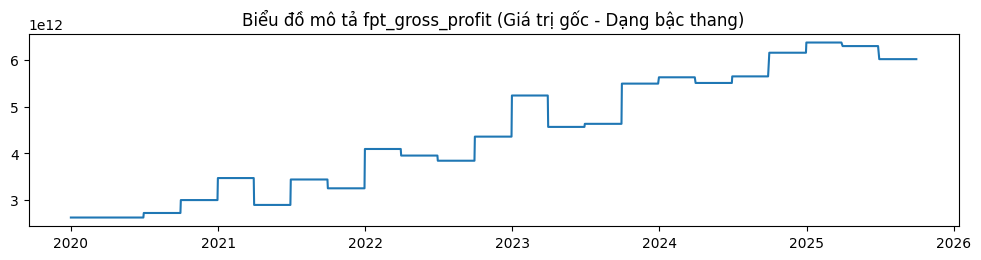

TIẾN HÀNH CHUẨN HÓA (StandardScaler)
✅ Đã xử lý fpt_gross_profit: Giữ nguyên xu hướng bậc thang và Scale.


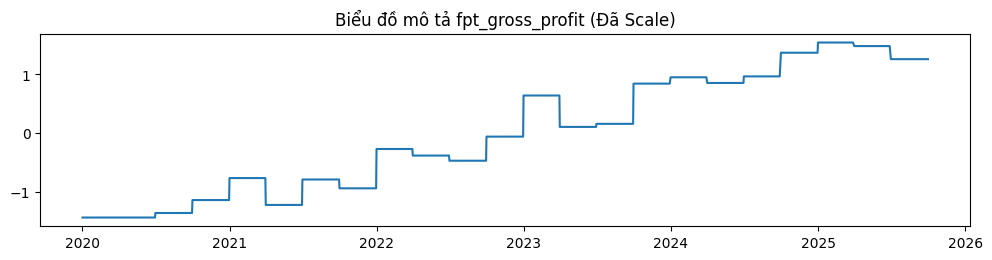

In [74]:
def EDA_fpt_gross_profit(_df = dataset) -> None:
    df = _df.copy()
    column_name = 'fpt_gross_profit'
    
    investigate_variable(df, column_name)
    
    # --- Điền mising value ---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()
    
    # --- Trực quan hóa ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Giá trị gốc - Dạng bậc thang)")
    plt.show() 

    # --- chuẩn hóa ---
    print('================================================')
    print('TIẾN HÀNH CHUẨN HÓA (StandardScaler)')
    print('================================================')
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    df[column_name] = pd.Series(scaled_data.flatten(), index=df.index)
    
    # --- Trực quan hóa sau scale ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Đã Scale)")
    plt.show()

EDA_fpt_gross_profit(dataset)

In [75]:
dataset.columns

Index(['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate',
       'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit',
       'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price',
       'fpt_stock_volume'],
      dtype='object')

## 3.9. `fpt_operating_profit`


----- THỐNG KÊ GIÁ TRỊ MISSING fpt_operating_profit -----
Tổng số giá trị khả dụng   : 22
Tổng số giá trị rỗng       : 1507
Tỉ lệ giá trị rỗng         : 98.56%

----- CHỈ SỐ THỐNG KÊ CHO CỘT fpt_operating_profit -----
Giá trị trung bình         : 2057070015306.4548
Giá trị nhỏ nhất           : 1127536485672.0
Q1 (25th percentile)       : 1538503668002.75
Q2 (Trung vị)              : 1985959843146.0
Q3 (75th percentile)       : 2496235600245.25
Giá trị lớn nhất           : 3129408582030.0
IQR                        : 957731932242.5


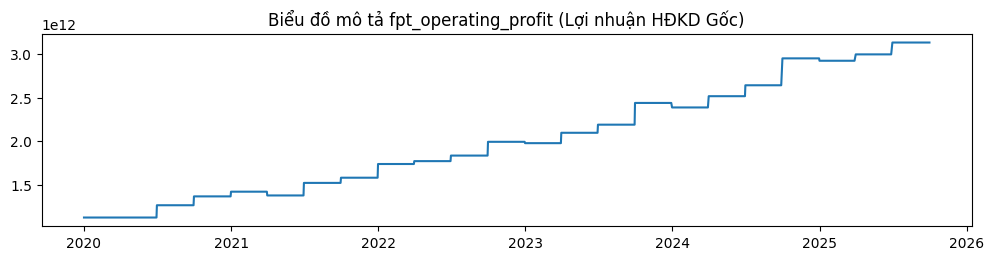

TIẾN HÀNH CHUẨN HÓA (StandardScaler)
✅ Đã hoàn tất xử lý cho fpt_operating_profit. Dữ liệu đã được Scale và sẵn sàng cho XGBoost.


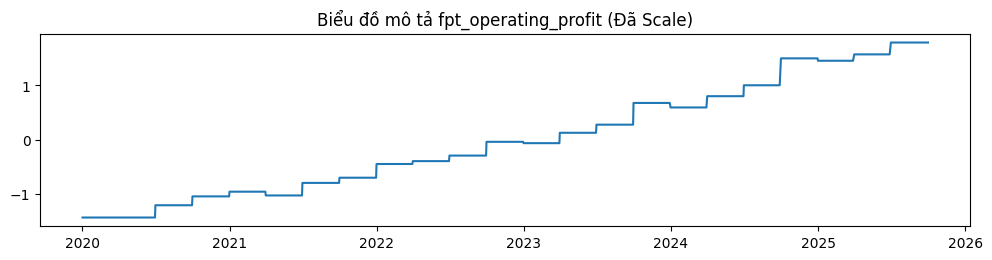

In [81]:
def EDA_fpt_operating_profit(_df = dataset) -> None:
    df = _df.copy()
    column_name = 'fpt_operating_profit' 
    
    investigate_variable(df, column_name)
    
    # --- điền missing value ---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()

    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Lợi nhuận HĐKD Gốc)")
    plt.show() 

    # --- Chuẩn hóa ---
    print('================================================')
    print('TIẾN HÀNH CHUẨN HÓA (StandardScaler)')
    print('================================================')
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    df[column_name] = pd.Series(scaled_data.flatten(), index=df.index)
    
    print(f"✅ Đã hoàn tất xử lý cho {column_name}. Dữ liệu đã được Scale và sẵn sàng cho XGBoost.")
    
    # --- Trực quan hóa sau scale ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Đã Scale)")
    plt.show()
EDA_fpt_operating_profit(dataset)

## 3.10. `fpt_net_profit`


----- THỐNG KÊ GIÁ TRỊ MISSING fpt_net_profit -----
Tổng số giá trị khả dụng   : 22
Tổng số giá trị rỗng       : 1507
Tỉ lệ giá trị rỗng         : 98.56%

----- CHỈ SỐ THỐNG KÊ CHO CỘT fpt_net_profit -----
Giá trị trung bình         : 1451097875461.0454
Giá trị nhỏ nhất           : 747105139041.0
Q1 (25th percentile)       : 1031232991464.0
Q2 (Trung vị)              : 1402658693392.5
Q3 (75th percentile)       : 1783358237707.0
Giá trị lớn nhất           : 2257462588123.0
IQR                        : 752125246243.0


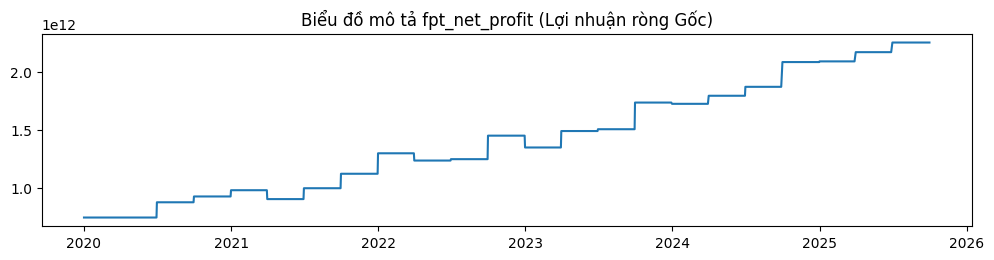

TIẾN HÀNH CHUẨN HÓA (StandardScaler)
✅ Đã hoàn tất xử lý cho fpt_net_profit. Dữ liệu đã được Scale và sẵn sàng cho XGBoost.


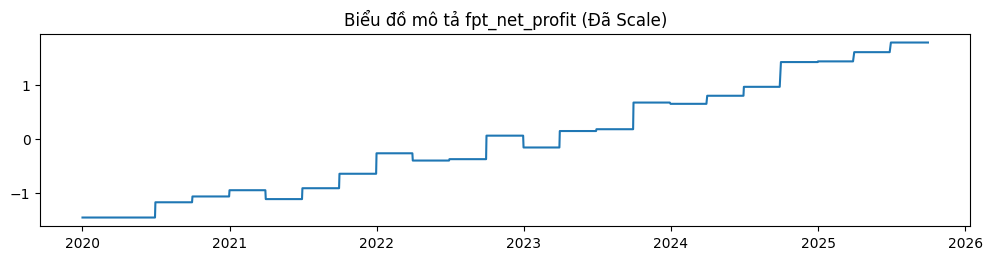

In [82]:
def EDA_fpt_net_profit(_df = dataset) -> None:
    df = _df.copy()
    column_name = 'fpt_net_profit'
    
    investigate_variable(df, column_name)
    
    # --- Điền missing value ---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()
    
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Lợi nhuận ròng Gốc)")
    plt.show() 

    # --- Chuẩn hóa ---
    print('================================================')
    print('TIẾN HÀNH CHUẨN HÓA (StandardScaler)')
    print('================================================')
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    df[column_name] = pd.Series(scaled_data.flatten(), index=df.index)
    
    print(f"✅ Đã hoàn tất xử lý cho {column_name}. Dữ liệu đã được Scale và sẵn sàng cho XGBoost.")
    
    # --- Trực quan hóa sau scale ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Đã Scale)")
    plt.show()

EDA_fpt_net_profit(dataset)

In [83]:
dataset.columns

Index(['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate',
       'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit',
       'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price',
       'fpt_stock_volume'],
      dtype='object')

## 3.11. `fpt_stock_price`


----- THỐNG KÊ GIÁ TRỊ MISSING fpt_stock_price -----
Tổng số giá trị khả dụng   : 1433
Tổng số giá trị rỗng       : 96
Tỉ lệ giá trị rỗng         : 6.28%

----- CHỈ SỐ THỐNG KÊ CHO CỘT fpt_stock_price -----
Giá trị trung bình         : 61.73882
Giá trị nhỏ nhất           : 14.75
Q1 (25th percentile)       : 42.53
Q2 (Trung vị)              : 51.27
Q3 (75th percentile)       : 86.59
Giá trị lớn nhất           : 133.04
IQR                        : 44.06


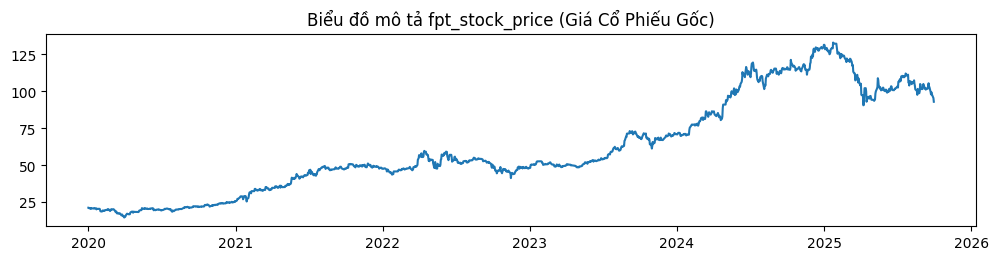

TIẾN HÀNH SAI PHÂN LOG (Tạo Daily Returns)


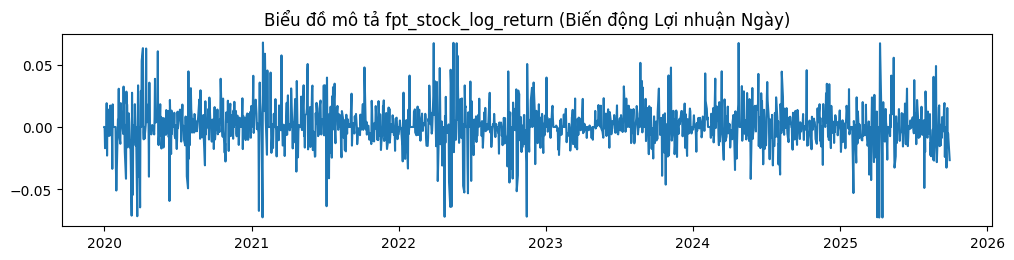


----- BẮT ĐẦU PHÂN TÍCH DECOMPOSITION: fpt_stock_log_return (Freq: M) -----


/tmp/ipykernel_48/2710428928.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  series_freq = series.asfreq(freq)


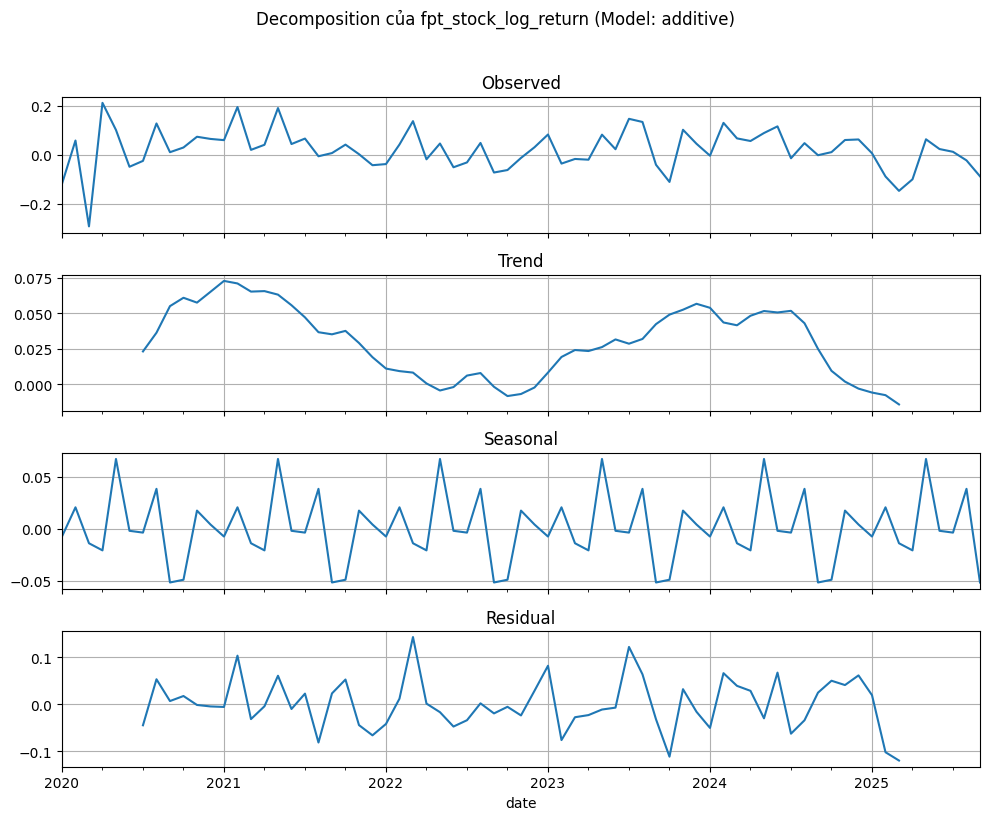


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Phần dư (Residuals) của Stock Returns -----
Chỉ số ADF (ADF Statistic)      : -2.8038
Giá trị p (P-value)             : 0.195543
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1755
  5%: -3.5130
  10%: -3.1867
--------------------------------------------------
KẾT LUẬN: Chuỗi KHÔNG CÓ TÍNH DỪNG (P-value >= 0.05). Chấp nhận H0.
--------------------------------------------------


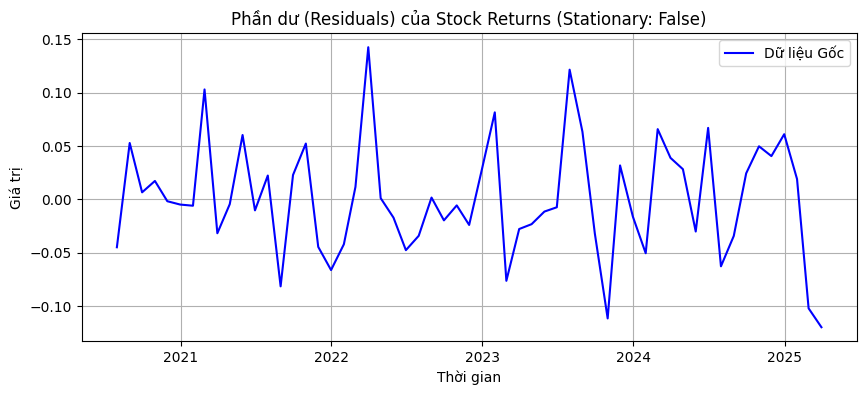


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Stock Log Return Đã Khử Mùa vụ -----
Chỉ số ADF (ADF Statistic)      : -5.2403
Giá trị p (P-value)             : 0.000073
Ngưỡng ý nghĩa (Critical Value) :
  1%: -4.1303
  5%: -3.4920
  10%: -3.1746
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


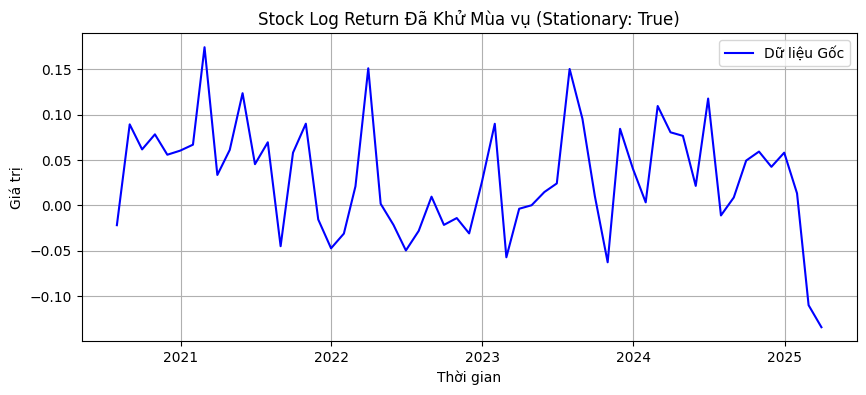

✅ Đã hoàn tất xử lý cho fpt_stock_log_return. Dữ liệu đã được Scale và sẵn sàng cho XGBoost.


In [87]:
def EDA_fpt_stock_price(_df = dataset) -> None:
    df = _df.copy()
    column_name = 'fpt_stock_price'
    new_column_name = 'fpt_stock_log_return'
    
    investigate_variable(df, column_name)
    
    # --- Điền missing value ---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()
    
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Giá Cổ Phiếu Gốc)")
    plt.show() 

    # --- Lấy sai phân ---
    print('================================================')
    print('TIẾN HÀNH SAI PHÂN LOG (Tạo Daily Returns)')
    print('================================================')
    df[new_column_name] = log_differencing(df[column_name], periods=1)
    column_name = new_column_name
    df[column_name] = df[column_name].bfill()
    df[column_name] = df[column_name].ffill()
    
    # --- Trực quan hóa sau sai phân và phân rã ---
    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Biến động Lợi nhuận Ngày)")
    plt.show() 

    df_monthly_analysis = df.set_index('date')[column_name].resample('ME').sum().to_frame()

    decomposed = decompose_time_series(
        df_monthly_analysis.reset_index(),
        column_name,
        date_name='date',
        period=12,        
        model='additive',
        freq='M' 
    )
    
    if decomposed is None:
        print("PHÂN TÍCH DECOMPOSITION THẤT BẠI.")
        return

    is_resid_stationary, p_resid = check_stationarity(
        decomposed.resid.dropna(), 
        title='Phần dư (Residuals) của Stock Returns'
    )
    
    stock_sa = decomposed.trend.dropna() + decomposed.resid.dropna()
    result_sa = check_stationarity(
        stock_sa, 
        title='Stock Log Return Đã Khử Mùa vụ'
    )
    
    # --- Chuẩn hóa ---
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    df[column_name] = pd.Series(scaled_data.flatten(), index=df.index)

EDA_fpt_stock_price(dataset)

In [88]:
dataset.columns

Index(['date', 'cpi_rate', 'gdp_value', 'usd_vnd_rate', 'xau_usd_rate',
       'market_cap', 'pe_ratio', 'fpt_net_revenue', 'fpt_gross_profit',
       'fpt_operating_profit', 'fpt_net_profit', 'fpt_stock_price',
       'fpt_stock_volume'],
      dtype='object')

## 3.12. `fpt_stock_volume`


----- THỐNG KÊ GIÁ TRỊ MISSING fpt_stock_volume -----
Tổng số giá trị khả dụng   : 1433
Tổng số giá trị rỗng       : 96
Tỉ lệ giá trị rỗng         : 6.28%

----- CHỈ SỐ THỐNG KÊ CHO CỘT fpt_stock_volume -----
Giá trị trung bình         : 2976653.81438
Giá trị nhỏ nhất           : 221966.0
Q1 (25th percentile)       : 1291360.0
Q2 (Trung vị)              : 2098979.0
Q3 (75th percentile)       : 3472300.0
Giá trị lớn nhất           : 23514300.0
IQR                        : 2180940.0


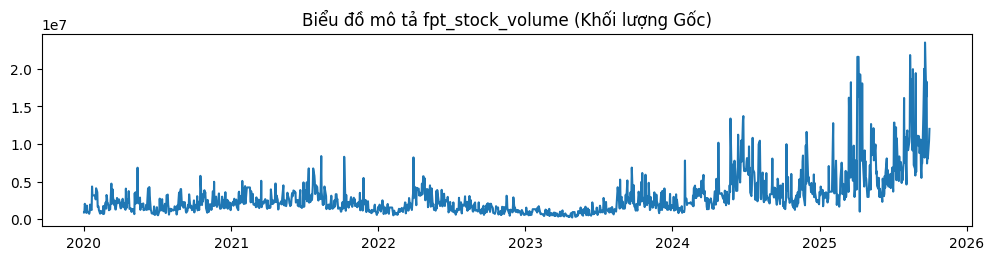

TIẾN HÀNH SAI PHÂN LOG (Phát hiện Nổ Vol)


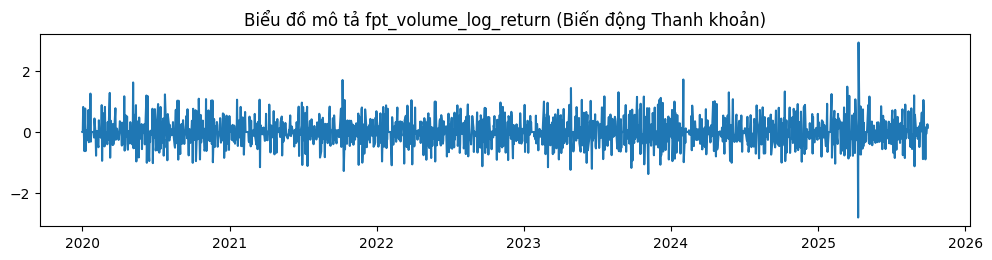


----- BẮT ĐẦU PHÂN TÍCH DECOMPOSITION: fpt_volume_log_return (Freq: D) -----


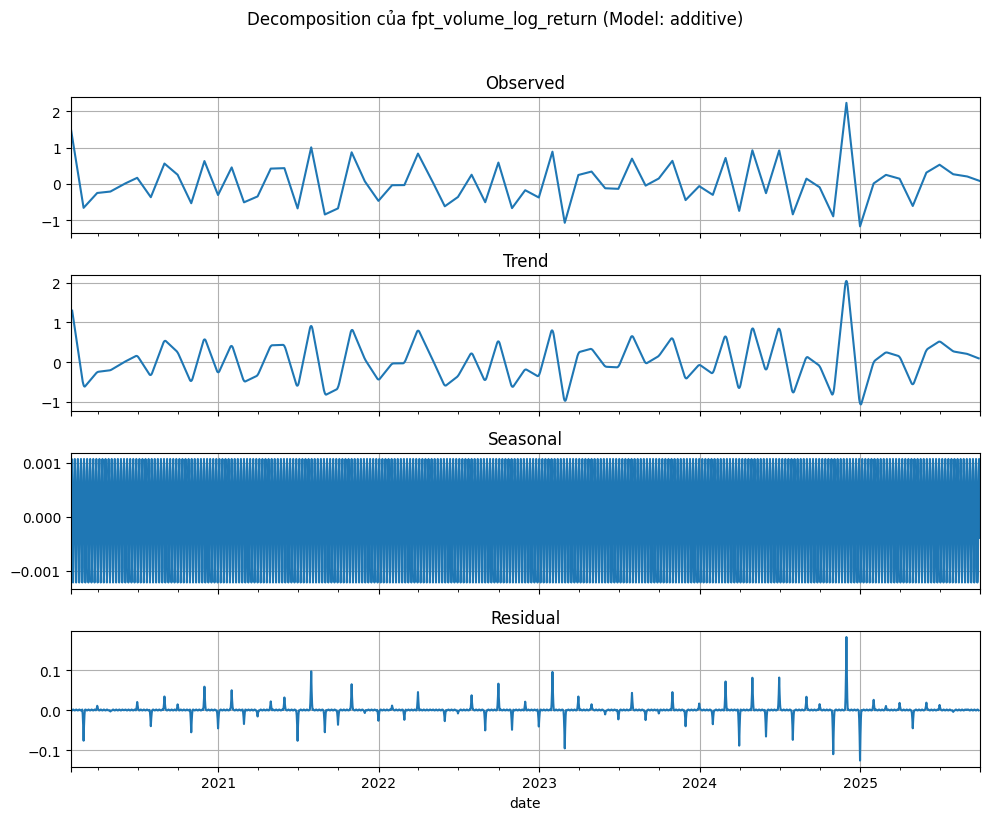


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Phần dư (Residuals) của Volume Change -----
Chỉ số ADF (ADF Statistic)      : -17.3708
Giá trị p (P-value)             : 0.000000
Ngưỡng ý nghĩa (Critical Value) :
  1%: -3.9632
  5%: -3.4126
  10%: -3.1283
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


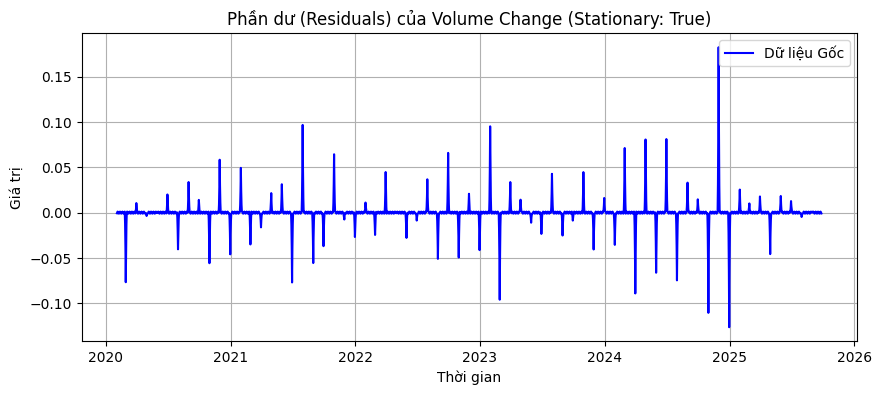


----- KIỂM ĐỊNH TÍNH DỪNG (ADF) CHO: Volume Log Return Đã Khử Mùa vụ -----
Chỉ số ADF (ADF Statistic)      : -11.4343
Giá trị p (P-value)             : 0.000000
Ngưỡng ý nghĩa (Critical Value) :
  1%: -3.9632
  5%: -3.4126
  10%: -3.1283
--------------------------------------------------
KẾT LUẬN: Chuỗi CÓ TÍNH DỪNG (P-value < 0.05). Bác bỏ H0.
--------------------------------------------------


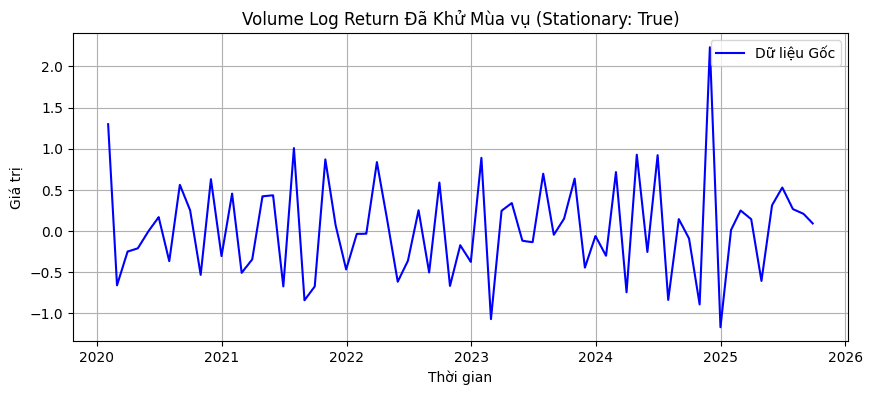

✅ Đã hoàn tất xử lý cho fpt_volume_log_return. Dữ liệu đã được Scale và sẵn sàng cho XGBoost.


In [90]:
def EDA_fpt_stock_volume(_df = dataset) -> None:
    df = _df.copy()
    column_name = 'fpt_stock_volume'
    new_column_name = 'fpt_volume_log_return'
    
    investigate_variable(df, column_name)
    
    # --- điền missing value ---
    df[column_name] = df[column_name].ffill()
    df[column_name] = df[column_name].bfill()
    df[column_name] = df[column_name].replace(0, 1) 

    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Khối lượng Gốc)")
    plt.show() 

    # --- Sai phân log ---
    print('================================================')
    print('TIẾN HÀNH SAI PHÂN LOG (Phát hiện Nổ Vol)')
    print('================================================')
    df[new_column_name] = log_differencing(df[column_name], periods=1)
    column_name = new_column_name
    df[column_name] = df[column_name].bfill()
    df[column_name] = df[column_name].ffill()

    plt.figure(figsize=(12, 2.5))
    plt.plot(df['date'], df[column_name])
    plt.title(f"Biểu đồ mô tả {column_name} (Biến động Thanh khoản)")
    plt.show() 
    

    # --- Phân rã ---
    df_monthly_analysis = df.set_index('date')[column_name].resample('ME').sum().to_frame()

    decomposed = decompose_time_series(
        df_monthly_analysis.reset_index(),
        column_name,
        date_name='date',
        period=7,        
        model='additive', 
        freq='D' 
    )
    
    if decomposed is None:
        print("PHÂN TÍCH DECOMPOSITION THẤT BẠI.")
        return

    # --- Kiểm định tính dừng ---
    is_resid_stationary, p_resid = check_stationarity(
        decomposed.resid.dropna(), 
        title='Phần dư (Residuals) của Volume Change'
    )
    
    vol_sa = decomposed.trend.dropna() + decomposed.resid.dropna()
    result_sa = check_stationarity(
        vol_sa, 
        title='Volume Log Return Đã Khử Mùa vụ'
    )
    
    # --- Chuẩn hóa ---
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    
    df[column_name] = pd.Series(scaled_data.flatten(), index=df.index)

EDA_fpt_stock_volume(dataset)

## 3.13. TIỀN XỬ LÝ TỔNG

In [94]:
def preprocessing(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Hàm tiền xử lý dữ liệu tổng hợp từ các bước EDA.
    1. Điền giá trị thiếu (Missing Value Imputation).
    2. Tạo biến Log Return cho các chuỗi thời gian biến động.
    3. Chuẩn hóa (Scaling) dữ liệu.
    
    Input: dataset gốc
    Output: dataset đã preprocessed (giữ nguyên cột cũ + thêm cột mới đã scale)
    """
    df = dataset.copy()
    
    # ---------------------------------------------------------
    # NHÓM 1: CÁC BIẾN CẦN TÍNH LOG RETURN + SCALE
    # ---------------------------------------------------------
    log_return_cols = [
        'cpi_rate', 
        'usd_vnd_rate', 
        'xau_usd_rate', 
        'pe_ratio', 
        'fpt_stock_price', 
        'fpt_stock_volume'
    ]
    
    existing_log_cols = [col for col in log_return_cols if col in df.columns]
    
    scaler = StandardScaler()
    
    for col in existing_log_cols:
        # --- Lấy sai phân ---
        df[col] = df[col].ffill().bfill()
        new_col_name = f"{col}_log_return" 
        df[new_col_name] = log_differencing(df[col], periods=1)
        df[new_col_name] = df[new_col_name].bfill().ffill()
        
        # --- Scale biến mới tạo ---
        scaled_data = scaler.fit_transform(df[new_col_name].values.reshape(-1, 1))
        df[new_col_name] = pd.Series(scaled_data.flatten(), index=df.index)

    # ---------------------------------------------------------
    # NHÓM 2: CÁC BIẾN CHỈ CẦN SCALE (KHÔNG TÍNH LOG RETURN)
    # ---------------------------------------------------------
    scale_only_cols = [
        'gdp_value', 
        'market_cap', 
        'fpt_net_revenue', 
        'fpt_gross_profit', 
        'fpt_operating_profit', 
        'fpt_net_profit'
    ]
    
    existing_scale_cols = [col for col in scale_only_cols if col in df.columns]
    
    for col in existing_scale_cols:
        # --- Điền khuyết ---
        df[col] = df[col].ffill().bfill()
        
        # --- Scale ---
        new_col_name = f"{col}_scaled"
        scaled_data = scaler.fit_transform(df[col].values.reshape(-1, 1))
        df[new_col_name] = pd.Series(scaled_data.flatten(), index=df.index)

    return df

df_preprocessed = preprocessing(dataset)
print(len(df_preprocessed.columns))
print(len(df_preprocessed))

25
1529


In [95]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1529 entries, 3411 to 4939
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         1529 non-null   datetime64[ns]
 1   cpi_rate                     1529 non-null   float64       
 2   gdp_value                    1529 non-null   float64       
 3   usd_vnd_rate                 1529 non-null   float64       
 4   xau_usd_rate                 1529 non-null   float64       
 5   market_cap                   1529 non-null   float64       
 6   pe_ratio                     1529 non-null   float64       
 7   fpt_net_revenue              1529 non-null   float64       
 8   fpt_gross_profit             1529 non-null   float64       
 9   fpt_operating_profit         1529 non-null   float64       
 10  fpt_net_profit               1529 non-null   float64       
 11  fpt_stock_price              1529 non-null   

# 4. Phân tích tương quan

In [96]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

def calculate_corr_pvalues(df: pd.DataFrame):
    """
    Tính ma trận tương quan Pearson và ma trận P-value tương ứng.
    
    Input: DataFrame (đã xử lý missing value)
    Output: 
        - corr_matrix: Ma trận hệ số tương quan
        - p_value_matrix: Ma trận P-value
    """
    # Chỉ lấy các cột số
    df_numeric = df.select_dtypes(include=[np.number])
    cols = df_numeric.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols)
    p_value_matrix = pd.DataFrame(index=cols, columns=cols)
    
    # Tính toán từng cặp
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
                p_value_matrix.loc[col1, col2] = 0.0
            else:
                # Tính pearsonr
                corr, p_val = pearsonr(df_numeric[col1], df_numeric[col2])
                corr_matrix.loc[col1, col2] = corr
                p_value_matrix.loc[col1, col2] = p_val
                
    # Chuyển đổi kiểu dữ liệu sang float để dễ xử lý sau này
    corr_matrix = corr_matrix.astype(float)
    p_value_matrix = p_value_matrix.astype(float)
    
    return corr_matrix, p_value_matrix

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_significance_heatmap(corr_matrix, p_value_matrix, figsize=(12, 10), title="Correlation Matrix", threshold=0.5):
    """
    Vẽ heatmap và TRẢ VỀ danh sách các biến ĐỘC LẬP (không bị đa cộng tuyến).
    
    Cơ chế lọc:
    - Duyệt qua từng cặp biến.
    - Nếu tương quan > threshold (và p-value < 0.05): Loại bỏ biến phía sau, giữ biến phía trước.
    
    Returns:
        final_features (list): Danh sách các biến ĐÃ ĐƯỢC CHỌN LỌC (Sạch).
    """
    # --- Vẽ Heatmap ---
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
                vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title(title)
    plt.show()

    # --- Loại bỏ biến đa cộng tuyến ---
    cols = corr_matrix.columns
    drop_cols = set()
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            col1 = cols[i]
            col2 = cols[j]
            
            if col2 in drop_cols:
                continue
                
            p_val = p_value_matrix.loc[col1, col2]
            corr = corr_matrix.loc[col1, col2]
            
            if p_val < 0.05 and abs(corr) > threshold:
                print(f"❌ Loại bỏ '{col2}' vì tương quan cao với '{col1}' (Corr={corr:.2f})")
                drop_cols.add(col2)

    # --- Tạo danh sách cuối cùng ---
    final_features = [c for c in cols if c not in drop_cols]
    
    print("\n" + "="*50)
    print("✅ DANH SÁCH BIẾN CUỐI CÙNG (SẠCH) ĐỂ CHẠY MODEL:")
    print(final_features)
    print("="*50)
    
    return final_features

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


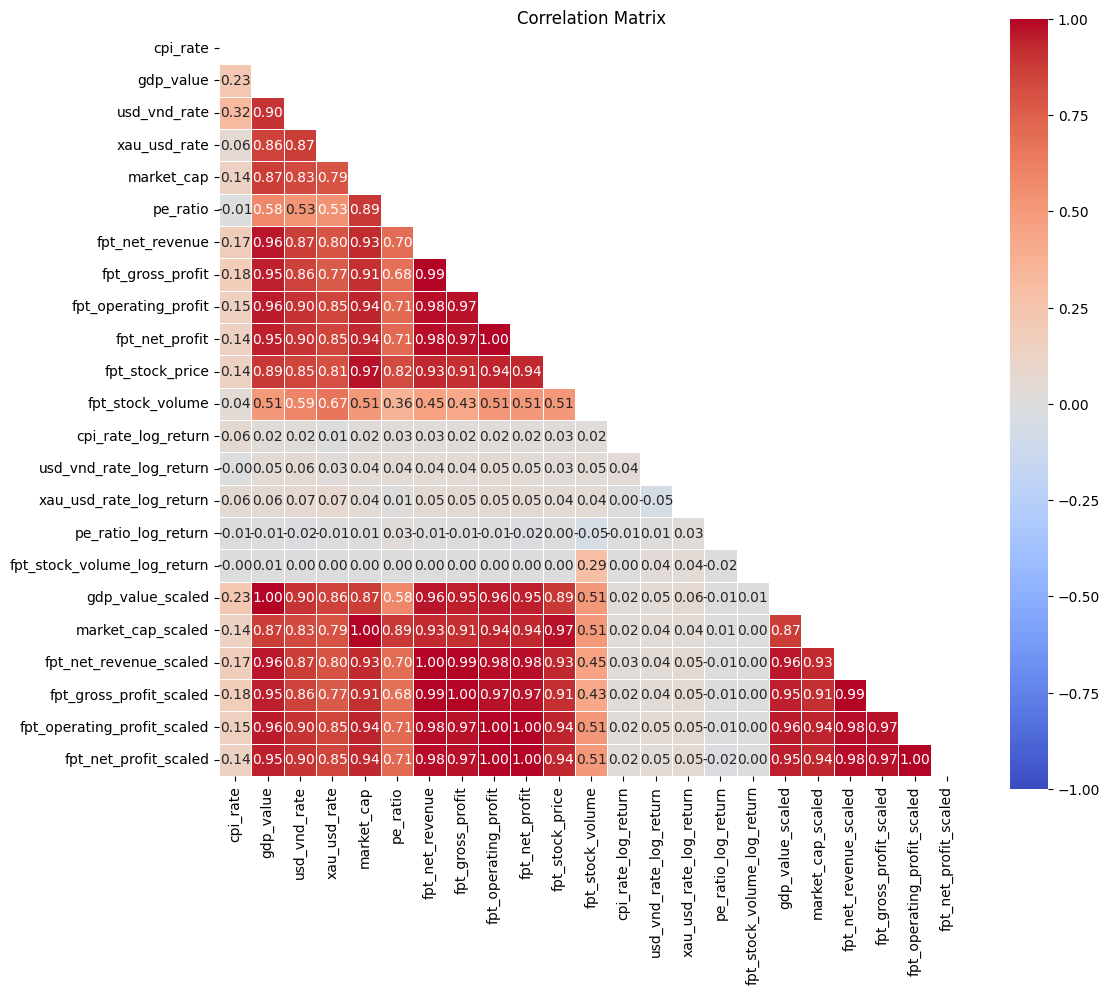

❌ Loại bỏ 'usd_vnd_rate' vì tương quan cao với 'gdp_value' (Corr=0.90)
❌ Loại bỏ 'xau_usd_rate' vì tương quan cao với 'gdp_value' (Corr=0.86)
❌ Loại bỏ 'market_cap' vì tương quan cao với 'gdp_value' (Corr=0.87)
❌ Loại bỏ 'pe_ratio' vì tương quan cao với 'gdp_value' (Corr=0.58)
❌ Loại bỏ 'fpt_net_revenue' vì tương quan cao với 'gdp_value' (Corr=0.96)
❌ Loại bỏ 'fpt_gross_profit' vì tương quan cao với 'gdp_value' (Corr=0.95)
❌ Loại bỏ 'fpt_operating_profit' vì tương quan cao với 'gdp_value' (Corr=0.96)
❌ Loại bỏ 'fpt_net_profit' vì tương quan cao với 'gdp_value' (Corr=0.95)
❌ Loại bỏ 'fpt_stock_price' vì tương quan cao với 'gdp_value' (Corr=0.89)
❌ Loại bỏ 'fpt_stock_volume' vì tương quan cao với 'gdp_value' (Corr=0.51)
❌ Loại bỏ 'gdp_value_scaled' vì tương quan cao với 'gdp_value' (Corr=1.00)
❌ Loại bỏ 'market_cap_scaled' vì tương quan cao với 'gdp_value' (Corr=0.87)
❌ Loại bỏ 'fpt_net_revenue_scaled' vì tương quan cao với 'gdp_value' (Corr=0.96)
❌ Loại bỏ 'fpt_gross_profit_scaled' vì t

In [110]:
df_clean = preprocessing(dataset)
cols_to_analyze = [c for c in df_clean.columns if c not in ['date', 'fpt_stock_price_log_return']]
df_input = df_clean[cols_to_analyze]
corr, p_vals = calculate_corr_pvalues(df_input)
variables = plot_significance_heatmap(corr, p_vals)

In [130]:
len(variables)
variables.extend(['date', 'fpt_stock_price', 'fpt_stock_price_log_return'])
variables = list(set(variables))
variables

['date',
 'cpi_rate',
 'xau_usd_rate_log_return',
 'pe_ratio_log_return',
 'fpt_stock_price',
 'gdp_value',
 'fpt_stock_price_log_return',
 'cpi_rate_log_return',
 'usd_vnd_rate_log_return',
 'fpt_stock_volume_log_return']

In [131]:
def filter_dataset(dataset: pd.DataFrame, variables: list) -> pd.DataFrame:
    valid_variables = [col for col in variables if col in dataset.columns]
    missing_variables = set(variables) - set(valid_variables)
    if missing_variables:
        print(f"⚠️ Cảnh báo: Các biến sau không tìm thấy trong dataset và sẽ bị bỏ qua: {missing_variables}")
    return dataset[valid_variables].copy()

In [132]:
a = filter_dataset(df_clean, variables)
a.to_csv('/kaggle/working/preprocessed_dataset.csv', index = False)